# MainFile

- Organizes information together to assist with the other files.
1. Takes synthetically generated problems in folder directories prepped already and simulates across them (`multiprocessing` and DES calls).
2. Reads the solutions in parallel (`multiprocessing`) and tidies the data into the aggregate level information (objective value results)

- Separately but crucially, it also housed where the visualizations were driven from. Likewise, there are also calculations for statistical evaluations (mixed effects model).

In [126]:
import pandas as pd
import numpy as np
import itertools

In [125]:
import os

# save tables
def save_df(df, file_name, folder_name=None, save_as='pkl'):
    if folder_name: 
        dir_path = os.path.join('ProblemSets', folder_name)
    else: # set default folder if none are provided
        dir_path = 'ProblemSets'  # Default folder
    
    # create directory if it doesn't exist
    os.makedirs(dir_path, exist_ok=True)
    
    # construct full file path
    file_path = os.path.join(dir_path,
                             f'{file_name}.{save_as}')
    
    # save based on format
    if save_as == 'txt':
        df.to_csv(file_path, 
                  sep='\t')  # Save as txt
    else:
        df.to_pickle(file_path)  # Save as pickle
    
    # print confirmation
    print(f"Data has been saved to '{file_path}'")

### Prepping Data 

#### Need to have a numpy matrix of the setup to setup of the recipe

In [5]:
setup_df= pd.read_pickle(f"RecipeToRecipe_Setups.pkl").unstack(level='Machine')
setup_df


Transition_Time_Hours         From_Temperature       \
Machine                                   1       2                1    2   
From_Recipe To_Recipe                                                       
(A, 6)      (A, 6)                   0.0000  0.0000               50   50   
            (A, 13)                  0.0500  0.0500               50   50   
            (A, 18)                  0.0000  0.0000               50   50   
            (B, 1)                   0.2500  0.2500               50   50   
            (B, 9)                   0.3000  0.3000               50   50   
...                                     ...     ...              ...  ...   
(D, 17)     (D, 10)                  0.0000  0.0000              350  350   
            (D, 12)                  0.0000  0.0000              350  350   
            (D, 15)                  0.4652  0.4652              350  350   
            (D, 16)                  0.2112  0.2112              350  350   
            (D, 17)                  0.0000  0.0000              350  350   

                      To_Temperature      Transition_Time_Minutes      
Machine                            1    2                       1   2  
From_Recipe To_Recipe                                                  
(A, 6)      (A, 6)                50   50                       0   0  
            (A, 13)               60   60                       3   8  
            (A, 18)               50   50                       0   0  
            (B, 1)               100  100                      15  20  
            (B, 9)               110  110                      18  23  
...                              ...  ...                     ...  ..  
(D, 17)     (D, 10)              350  350                       0   0  
            (D, 12)              350  350                       0   0  
            (D, 15)              250  250                      27  32  
            (D, 16)              300  300                      12  17  
            (D, 17)              350  350                       0   0  

[400 rows x 8 columns]

In [4]:
import pandas as pd

def get_setup_transition_times(setup_df, from_recipe, to_recipes, machine, debug=False):
    """Extract setup transition times, handling duplicates."""
    
    # Access times individually
    idx = pd.IndexSlice
    transition_times = [
        setup_df.loc[(from_recipe, to_recipe), idx['Transition_Time_Minutes', machine]]
        for to_recipe in to_recipes
    ]
    
    # Ensure 1D numpy array
    transition_times = np.array(transition_times).ravel()
    
    if debug:  # Print compact details
        print(f"Machine: {machine}; From recipe: {from_recipe}; To recipes: {to_recipes}")
        print("Transition Times (Minutes):", transition_times)
    
    return transition_times

# Example usage
from_recipe = ('A', 6)
to_recipes = [('A', 13), ('B', 1), ('B', 1), ('B', 9)]
machine = 1

# Call function
transition_times = get_setup_transition_times(setup_df, from_recipe, to_recipes, machine, debug=True)


Machine: 1; From recipe: ('A', 6); To recipes: [('A', 13), ('B', 1), ('B', 1), ('B', 9)]
Transition Times (Minutes): [ 3 15 15 18]


In [5]:
transition_times

array([ 3, 15, 15, 18])

#### index a job or jobs slice by 1-based indexing for RecipeCluster and Recipe 

In [10]:
QueueSize, ProblemNumber = 25, 1
print(f'QueueSize:{QueueSize}; ProblemNumber:{ProblemNumber}')

# Load problem df, and extract a and b arrays
problem_df = pd.read_pickle(f'ProblemSets/{QueueSize}Queue/Problem_{ProblemNumber}_jobs.pkl')
problem_df.iloc[:,:]

QueueSize:25; ProblemNumber:1


,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,Remaining_Minutes,Queue_Step,a,b,a_true,b_true,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,C,7,72,31,0.0,0,0,1525,0,1525,3,215,7
1,2,A,18,17,60,20.0,0,0,3500,0,3500,7,120,2
2,3,A,18,30,104,NaN,0,0,3500,0,3500,7,207,2
3,4,B,19,30,12,NaN,0,0,3500,0,3500,2,59,5
4,5,A,6,60,24,NaN,0,0,1450,0,1450,2,120,5
5,6,C,5,44,44,NaN,0,0,1550,0,1550,5,220,5
6,7,D,15,75,10000,NaN,0,0,1525,0,1525,2,150,0
7,8,D,16,28,10000,NaN,0,0,3500,0,3500,3,83,0
8,9,D,10,8,16,NaN,1,60,3560,50,3550,8,62,4
9,10,D,12,24,24,NaN,1,60,560,50,550,2,48,2


In [11]:
# Access Recipe_Cluster and Recipe as tuples
recipe_tuples = problem_df.apply(lambda row: (str(row['Recipe_Cluster']), row['Recipe']), 
                                 axis=1)

# Convert to list if needed
recipe_tuples_list = recipe_tuples.to_numpy()

arr_test = np.array([3, 4, 5, 6])-1 # 1-based indexing for jobs

recipe_tuples_list[arr_test]


array([('A', 18), ('B', 19), ('A', 6), ('C', 5)], dtype=object)

### Creating Run Plans 

One Time, do not delete, leave commented

In [3]:
pd.read_pickle(f"ProblemSets/Training_Solutions_Details.pkl")

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,10,1,1,AI_LPT,None,None
1,10,1,2,AI_LPT,None,None
2,10,1,3,AI_LPT,None,None
3,10,1,4,AI_LPT,None,None
4,10,1,5,AI_LPT,None,None
...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,None,None
46796,75,100,33,AI_LPT,None,None
46797,75,100,34,AI_LPT,None,None
46798,75,100,35,AI_LPT,None,None


In [345]:
# # Define parameters
# problem_sets = [10, 25, 75]
# problems_per_set = [750, 300, 100]
# solutions_per_problem = 36
# algorithms = ['AI_LPT']

# data = []

# for problem_set, num_problems in zip(problem_sets, problems_per_set):
#     problem_numbers = range(1, num_problems + 1)
    
#     for algorithm in algorithms:
#         solution_numbers = range(1, solutions_per_problem + 1)
#         combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
#         data.extend(combinations)

# # Convert to array
# data_array = np.array(data)

# # Create placeholders
# placeholders = np.full((data_array.shape[0], 2), None)
# final_data_array = np.hstack([data_array, placeholders])

# # Define columns
# columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# # Create DataFrame
# solutions_df = pd.DataFrame(final_data_array, columns=columns)

# # Save DataFrame
# save_df(solutions_df, 'Training_Solutions_Details')


Data has been saved to 'ProblemSets/Training_Solutions_Details.pkl'


In [127]:
# import itertools
# # Define parameters
# problem_sets = [25, 75]
# problems_per_set = [300, 100]
# solutions_per_problem = 36
# algorithms = ['AI_LPT']

# data = []

# for problem_set, num_problems in zip(problem_sets, problems_per_set):
#     problem_numbers = range(1, num_problems + 1)
    
#     for algorithm in algorithms:
#         solution_numbers = range(1, solutions_per_problem + 1)
#         combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
#         data.extend(combinations)

# # Convert to array
# data_array = np.array(data)

# # Create placeholders
# placeholders = np.full((data_array.shape[0], 2), None)
# final_data_array = np.hstack([data_array, placeholders])

# # Define columns
# columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# # Create DataFrame
# solutions_df = pd.DataFrame(final_data_array, columns=columns)

# # Save DataFrame
# save_df(solutions_df, 'Solutions_Details')


Data has been saved to 'ProblemSets/Solutions_Details.pkl'


### with `multiprocessing`: Running DES

In [128]:
### Training = False! Real DEAL
import pandas as pd
solutions_df = pd.read_pickle(f'ProblemSets/Solutions_Details.pkl')
solutions_df[(solutions_df['Algorithm'] == 'AI_LPT') & (solutions_df['AggregateSolutionData'].isna())]

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,25,1,1,AI_LPT,None,None
1,25,1,2,AI_LPT,None,None
2,25,1,3,AI_LPT,None,None
3,25,1,4,AI_LPT,None,None
4,25,1,5,AI_LPT,None,None
...,...,...,...,...,...,...
14395,75,100,32,AI_LPT,None,None
14396,75,100,33,AI_LPT,None,None
14397,75,100,34,AI_LPT,None,None
14398,75,100,35,AI_LPT,None,None


In [129]:
import pandas as pd
training_solutions_df = pd.read_pickle(f'ProblemSets/Training_Solutions_Details.pkl')
training_solutions_df[(training_solutions_df['Algorithm'] == 'AI_LPT') & (training_solutions_df['AggregateSolutionData'].isna())]

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds


In [93]:
def create_sequencing_rule_combinations(filepath="SchedulingRule_Permutations.pkl"):
    """
    Load sequencing rules to cross-join and label.
    
    Args:
        filepath (str): Path to the pickle file with sequencing rules.
        
    Returns:
        pd.DataFrame: DataFrame with rule combinations, stacked matrices, and labels.
    """
    # Load data
    sequence_permutes = pd.read_pickle(filepath)

    # Create Cartesian product
    cartesian_product = sequence_permutes.merge(sequence_permutes, 
                                                how='cross', 
                                                suffixes=('_First', '_Second'))

    # Extract first/second matrices
    first_matrices = np.array(cartesian_product['SchedulingMatrix_First'].tolist())  # First machine
    second_matrices = np.array(cartesian_product['SchedulingMatrix_Second'].tolist())  # Second machine

    # Stack along axis=3
    stacked_matrices = np.stack([first_matrices, second_matrices], axis=3)  # Create 4x4x2

    # Add stacked matrices
    cartesian_product['CombinedMatrix'] = list(stacked_matrices)

    # Add rule labels
    cartesian_product['SequencingRuleLabel'] = list(zip(cartesian_product['SchedulingRule_First'], 
                                                        cartesian_product['SchedulingRule_Second']))
    # Add sequence labels
    cartesian_product['SequencingRuleLabelDefn'] = list(zip(cartesian_product['UniqueRecipeClusterSequence_First'], 
                                                            cartesian_product['UniqueRecipeClusterSequence_Second']))

    # Return selected columns
    return cartesian_product[['SequencingRuleLabel', 'SequencingRuleLabelDefn', 'CombinedMatrix']]

all_sequence_pair_rules = create_sequencing_rule_combinations()
all_sequence_pair_rules


,SequencingRuleLabel,SequencingRuleLabelDefn,CombinedMatrix
0,"(1, 1)","((A, B, D, C), (A, B, D, C))","[[[0, 0], [1, 1], [0, 0], [0, 0]], [[0, 0], [0..."
1,"(1, 2)","((A, B, D, C), (A, D, C, B))","[[[0, 0], [1, 0], [0, 0], [0, 1]], [[0, 1], [0..."
2,"(1, 3)","((A, B, D, C), (A, C, D, B))","[[[0, 0], [1, 0], [0, 1], [0, 0]], [[0, 1], [0..."
3,"(1, 4)","((A, B, D, C), (A, B, C, D))","[[[0, 0], [1, 1], [0, 0], [0, 0]], [[0, 0], [0..."
4,"(1, 5)","((A, B, D, C), (A, C, B, D))","[[[0, 0], [1, 0], [0, 1], [0, 0]], [[0, 0], [0..."
5,"(1, 6)","((A, B, D, C), (A, D, B, C))","[[[0, 0], [1, 0], [0, 0], [0, 1]], [[0, 0], [0..."
6,"(2, 1)","((A, D, C, B), (A, B, D, C))","[[[0, 0], [0, 1], [0, 0], [1, 0]], [[1, 0], [0..."
7,"(2, 2)","((A, D, C, B), (A, D, C, B))","[[[0, 0], [0, 0], [0, 0], [1, 1]], [[1, 1], [0..."
8,"(2, 3)","((A, D, C, B), (A, C, D, B))","[[[0, 0], [0, 0], [0, 1], [1, 0]], [[1, 1], [0..."
9,"(2, 4)","((A, D, C, B), (A, B, C, D))","[[[0, 0], [0, 1], [0, 0], [1, 0]], [[1, 0], [0..."


#### `Multiprocessing` simulations (DES)

In [92]:
import subprocess # needed for handling
import pandas as pd
import multiprocessing # parallel processing
from tqdm import tqdm # nifty status bar
import os
import json

# Run simulation DES
def run_simulation(queue_size, problem_number, solution_number, algorithm_type, is_arrival_time_expected, isTraining=False):
    """
    Execute discrete event simulation (DES) in parallel using parameters.

    Parameters:
        queue_size (int): Size of the job queue.
        problem_number (int): Problem number identifier.
        solution_number (int): Solution number identifier.
        algorithm_type (str): Type of algorithm to use (e.g., "AI_SPT").
        is_arrival_time_expected (bool): Whether arrival times are expected or not.
        isTraining (bool, optional): Indicates whether the simulation is part of training. Default is False.

    Returns:
        None
    """
    # Set `sort_lpt`
    sort_lpt = "False" if "_SPT" in algorithm_type else "True"
    
    # Set sequencing_rule
    if algorithm_type.startswith("AI_"):
        sequencing_rule = all_sequence_pair_rules['CombinedMatrix'][int(solution_number) - 1]
        sequencing_rule_str = json.dumps(sequencing_rule.tolist())  # Convert to JSON
    else:
        sequencing_rule_str = "None"

    # Convert None types to "None" strings explicitly
    sequencing_rule_str = str(sequencing_rule_str) if sequencing_rule_str is not None else "None"
    is_arrival_time_expected = str(is_arrival_time_expected) if is_arrival_time_expected is not None else "None"
    isTraining = str(isTraining) if isTraining is not None else "None"

    # Build command
    command = [
        "python", "DiscreteEventSimulation.py",
        "--QueueSize", str(queue_size),
        "--TrainingProblemSet", isTraining,
        "--ProblemNumber", str(problem_number),
        "--SolutionNumber", str(solution_number),
        "--AlgorithmType", algorithm_type,
        "--sort_lpt", sort_lpt,
        "--ArrivalTimes_expected", is_arrival_time_expected,
        "--sequencing_rule", sequencing_rule_str
    ]

    # Run command
    try:
        with open(os.devnull, 'w') as devnull:
            subprocess.run(command, stdout=devnull, stderr=devnull, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error encountered in command: {' '.join(command)}")
        print(f"Error: {e}")


# Wrapper function (this was tricky but suggested by chatGPT to bypass bugs I was getting)
def run_simulation_wrapper(args):
    """
    Wrapper for `run_simulation` to unpack arguments.

    Parameters:
        args (tuple): Tuple of arguments to pass to `run_simulation`.

    Returns:
        None
    """
    return run_simulation(*args)

# Controller for all simulations
def run_all_simulations(df, is_arrival_time_expected, isTraining=False):
    """
    Run all simulations for the df DataFrame in parallel.

    Parameters:
        df (pd.DataFrame): DataFrame containing simulation parameters.
        is_arrival_time_expected (bool): Whether arrival times are expected (a) or not (true arrivals, a_true).
        isTraining (bool, optional): Indicates where to save; isTraining as true puts in the training problem set. Default is False.

    Returns:
        None
    """
    # Prepare argument list
    args_list = [
        (row['ProblemSet'], row['ProblemNumber'], row['SolutionNumber'], row['Algorithm'], is_arrival_time_expected, isTraining)
        for _, row in df.iterrows() # go row by row from Run Plan
    ]

    # Set number of processes
    num_processes = min(multiprocessing.cpu_count() - 1, # 23 threads (out of 24)
                        len(args_list))

    # Run simulations in parallel
    with multiprocessing.Pool(processes=num_processes) as pool:
        for _ in tqdm(pool.imap_unordered(run_simulation_wrapper, 
                                          args_list), 
                      total=len(args_list)):
            pass

### Simulating `AI_LPT` and `AI_true_LPT` 

- `AI_LPT` was used for warm-starts (both training and validation and evaluations)
- `AI_true_LPT` was used for final comparison only (holdout set comparison)

In [ ]:
# Rerunning AI_LPT Because I made changes

In [348]:
# RUns the AI to start
# Main entry
if __name__ == "__main__": 
    run_all_simulations(training_solutions_df,
                        is_arrival_time_expected = True, # Not GodMode, this is to be fair
                        isTraining = True)

100%|█████████████████████████████████████████████████████████████████████████████| 46800/46800 [36:21<00:00, 21.46it/s]


In [11]:
#  100%|███ 46800/46800 [36:41<00:00, 21.26it/s] 
# it took 40 minutes (no errors!)

In [134]:
### Training = False! Real DEAL
# RUns the AI to start
# Main entry
if __name__ == "__main__": 
    run_all_simulations(solutions_df,
                        is_arrival_time_expected = True, # Not GodMode, this is to be fair
                        isTraining = False)


100%|█████████████████████████████████████████████████████████████████████████████| 14400/14400 [13:43<00:00, 17.48it/s]


### Simulating Traditional_LPT (Unused)

In [135]:
# Training = False! Real deal
# Define parameters
problem_sets = [25, 75]
problems_per_set = [300, 100]
solutions_per_problem = 1
algorithms = ['Traditional_LPT']

data = []

for problem_set, num_problems in zip(problem_sets, problems_per_set):
    problem_numbers = range(1, num_problems + 1)
    
    for algorithm in algorithms:
        solution_numbers = range(1, solutions_per_problem + 1)
        combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
        data.extend(combinations)

# Convert to array
data_array = np.array(data)

# Create placeholders
placeholders = np.full((data_array.shape[0], 2), None)
final_data_array = np.hstack([data_array, placeholders])

# Define columns
columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# Create DataFrame
solutions_df = pd.DataFrame(final_data_array, columns=columns)

# Save DataFrame
save_df(solutions_df, 'Solutions_Details_Traditional_LPT')


Data has been saved to 'ProblemSets/Solutions_Details_Traditional_LPT.pkl'


In [269]:
# Training
# Define parameters
problem_sets = [10, 25, 75]
problems_per_set = [750, 300, 100]
solutions_per_problem = 1
algorithms = ['Traditional_LPT']

data = []

for problem_set, num_problems in zip(problem_sets, problems_per_set):
    problem_numbers = range(1, num_problems + 1)
    
    for algorithm in algorithms:
        solution_numbers = range(1, solutions_per_problem + 1)
        combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
        data.extend(combinations)

# Convert to array
data_array = np.array(data)

# Create placeholders
placeholders = np.full((data_array.shape[0], 2), None)
final_data_array = np.hstack([data_array, placeholders])

# Define columns
columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# Create DataFrame
solutions_df = pd.DataFrame(final_data_array, columns=columns)

# Save DataFrame
save_df(solutions_df, 'Training_Solutions_Details_Traditional_LPT')


Data has been saved to 'ProblemSets/Training_Solutions_Details_Traditional_LPT.pkl'


In [138]:
training_solutions_df2 = pd.read_pickle(f'ProblemSets/Training_Solutions_Details_Traditional_LPT.pkl')
training_solutions_df2

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,Traditional_LPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ...",513,453.0,483.00,0.08
1,10,2,1,Traditional_LPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ...",349,412.5,380.75,0.06
2,10,3,1,Traditional_LPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ...",710,353.0,531.50,0.06
3,10,4,1,Traditional_LPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ...",632,305.0,468.50,0.06
4,10,5,1,Traditional_LPT,None,"{'max_flow_time': 635, 'avg_makespan': 445.5, ...",635,445.5,540.25,0.06
...,...,...,...,...,...,...,...,...,...,...
1295,75,96,1,Traditional_LPT,None,"{'max_flow_time': 2709, 'avg_makespan': 2599.5...",2709,2599.5,2654.25,1.20
1296,75,97,1,Traditional_LPT,None,"{'max_flow_time': 2618, 'avg_makespan': 2600.5...",2618,2600.5,2609.25,1.18
1297,75,98,1,Traditional_LPT,None,"{'max_flow_time': 2543, 'avg_makespan': 2532.5...",2543,2532.5,2537.75,1.21
1298,75,99,1,Traditional_LPT,None,"{'max_flow_time': 3109, 'avg_makespan': 2976.0...",3109,2976.0,3042.50,1.07


In [137]:
solutions_df2 = pd.read_pickle(f'ProblemSets/Solutions_Details_Traditional_LPT.pkl')
solutions_df2

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,25,1,1,Traditional_LPT,None,None
1,25,2,1,Traditional_LPT,None,None
2,25,3,1,Traditional_LPT,None,None
3,25,4,1,Traditional_LPT,None,None
4,25,5,1,Traditional_LPT,None,None
...,...,...,...,...,...,...
395,75,96,1,Traditional_LPT,None,None
396,75,97,1,Traditional_LPT,None,None
397,75,98,1,Traditional_LPT,None,None
398,75,99,1,Traditional_LPT,None,None


### Simulating Traditional_true_SPT (Baseline comparison for everything)

In [243]:
# Define parameters
problem_sets = [25, 75]
problems_per_set = [300, 100]
solutions_per_problem = 1
algorithms = ['Traditional_true_SPT']

data = []

for problem_set, num_problems in zip(problem_sets, problems_per_set):
    problem_numbers = range(1, num_problems + 1)
    
    for algorithm in algorithms:
        solution_numbers = range(1, solutions_per_problem + 1)
        combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
        data.extend(combinations)

# Convert to array
data_array = np.array(data)

# Create placeholders
placeholders = np.full((data_array.shape[0], 2), None)
final_data_array = np.hstack([data_array, placeholders])

# Define columns
columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# Create DataFrame
solutions_df = pd.DataFrame(final_data_array, columns=columns)

# Save DataFrame
save_df(solutions_df, 'Training_Solutions_Details_Traditional_true_SPT')


Data has been saved to 'ProblemSets/Training_Solutions_Details_Traditional_true_SPT.pkl'


In [247]:
training_solutions_df4 = pd.read_pickle(f'ProblemSets/Training_Solutions_Details_Traditional_true_SPT.pkl')
training_solutions_df4

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,25,1,1,Traditional_true_SPT,None,None
1,25,2,1,Traditional_true_SPT,None,None
2,25,3,1,Traditional_true_SPT,None,None
3,25,4,1,Traditional_true_SPT,None,None
4,25,5,1,Traditional_true_SPT,None,None
...,...,...,...,...,...,...
395,75,96,1,Traditional_true_SPT,None,None
396,75,97,1,Traditional_true_SPT,None,None
397,75,98,1,Traditional_true_SPT,None,None
398,75,99,1,Traditional_true_SPT,None,None


In [248]:
#### Run the traditional too in the trainer !!!!!!!!!!!!!!

# Main entry
if __name__ == "__main__": 
    run_all_simulations(training_solutions_df4, 
                        is_arrival_time_expected = False, # Actual
                        isTraining=True)
    run_all_simulations(training_solutions_df4, 
                    is_arrival_time_expected = False, # Actual
                    isTraining=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:26<00:00, 15.18it/s]


### Simulating Traditional_SPT (Less useful, unused)

In [300]:
# Define parameters
problem_sets = [10, 25, 75]
problems_per_set = [750, 300, 100]
solutions_per_problem = 1
algorithms = ['Traditional_SPT']

data = []

for problem_set, num_problems in zip(problem_sets, problems_per_set):
    problem_numbers = range(1, num_problems + 1)
    
    for algorithm in algorithms:
        solution_numbers = range(1, solutions_per_problem + 1)
        combinations = itertools.product([problem_set], problem_numbers, solution_numbers, [algorithm])
        data.extend(combinations)

# Convert to array
data_array = np.array(data)

# Create placeholders
placeholders = np.full((data_array.shape[0], 2), None)
final_data_array = np.hstack([data_array, placeholders])

# Define columns
columns = ['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']

# Create DataFrame
solutions_df = pd.DataFrame(final_data_array, columns=columns)

# Save DataFrame
save_df(solutions_df, 'Training_Solutions_Details_Traditional_SPT')


Data has been saved to 'ProblemSets/Training_Solutions_Details_Traditional_SPT.pkl'


In [308]:
training_solutions_df3 = pd.read_pickle(f'ProblemSets/Training_Solutions_Details_Traditional_SPT.pkl')
training_solutions_df3

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,10,1,1,Traditional_SPT,None,None
1,10,2,1,Traditional_SPT,None,None
2,10,3,1,Traditional_SPT,None,None
3,10,4,1,Traditional_SPT,None,None
4,10,5,1,Traditional_SPT,None,None
...,...,...,...,...,...,...
1295,75,96,1,Traditional_SPT,None,None
1296,75,97,1,Traditional_SPT,None,None
1297,75,98,1,Traditional_SPT,None,None
1298,75,99,1,Traditional_SPT,None,None


In [321]:
#### Run the traditional too in the trainer !!!!!!!!!!!!!!

# Main entry
if __name__ == "__main__": 
    run_all_simulations(training_solutions_df3, 
                        is_arrival_time_expected = True, # Not GodMode, this is to be fair
                        isTraining=True)

 58%|██████████████████████████████████████████████▏                                 | 750/1300 [00:31<00:17, 31.39it/s]

Error encountered in command: python DiscreteEventSimulation.py --QueueSize 25 --TrainingProblemSet True --ProblemNumber 1 --SolutionNumber 1 --AlgorithmType Traditional_SPT --sort_lpt False --ArrivalTimes_expected True --sequencing_rule None
Error: Command '['python', 'DiscreteEventSimulation.py', '--QueueSize', '25', '--TrainingProblemSet', 'True', '--ProblemNumber', '1', '--SolutionNumber', '1', '--AlgorithmType', 'Traditional_SPT', '--sort_lpt', 'False', '--ArrivalTimes_expected', 'True', '--sequencing_rule', 'None']' returned non-zero exit status 1.


100%|███████████████████████████████████████████████████████████████████████████████| 1300/1300 [01:05<00:00, 19.70it/s]


In [140]:
### Training is not false! Real deal
# Main entry
if __name__ == "__main__": 
    run_all_simulations(solutions_df2, 
                        is_arrival_time_expected = True, # Not GodMode, this is to be fair
                        isTraining=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:25<00:00, 15.53it/s]


#### Debugging tool for calling DES Python script

In [320]:
import json
import numpy as np

# Parameters for testing
queue_size = 10
problem_number = 1
solution_number = 1
algorithm_type = "Traditional_SPT"
isTraining = True

# Determine `sequencing_rule` for AI algorithms
if algorithm_type.startswith("AI_"):
    sequencing_rule = all_sequence_pair_rules['CombinedMatrix'][solution_number - 1]
else:
    sequencing_rule = None

# Convert `sequencing_rule` to a properly formatted string
if sequencing_rule is not None:
    sequencing_rule_str = json.dumps(sequencing_rule.tolist())  # Convert numpy array to JSON-compatible list format
else:
    sequencing_rule_str = "None"

# Set `sort_lpt`
sort_lpt = "False" if "_SPT" in algorithm_type else "True"

# Build the command string
command_str = (
    f"python DiscreteEventSimulation.py "
    f"--QueueSize {queue_size} "
    f"--TrainingProblemSet {str(isTraining)} "
    f"--ProblemNumber {problem_number} "
    f"--SolutionNumber {solution_number} "
    f"--AlgorithmType {algorithm_type} "
    f"--sort_lpt {sort_lpt} "
    f"--ArrivalTimes_expected {str(True)} "
    f"--sequencing_rule '{sequencing_rule_str}'"
)

print(command_str)

python DiscreteEventSimulation.py --QueueSize 10 --TrainingProblemSet True --ProblemNumber 1 --SolutionNumber 1 --AlgorithmType Traditional_SPT --sort_lpt False --ArrivalTimes_expected True --sequencing_rule 'None'


## Reading in the solution files

In [5]:
# Define file path
file_path_str = 'ProblemSets/Training_Solutions_Details.pkl'
isTraining = 'Training' in file_path_str


In [6]:
import pandas as pd
from tqdm import tqdm
import multiprocessing

# Load and filter data
def load_and_filter_solution(file_path, exclude_keys=None):
    exclude_keys = exclude_keys or []
    try:
        data = pd.read_pickle(file_path)
        data = {k: v for k, v in data.items() if k not in exclude_keys}
        return data
    except Exception as e:
        print(f"[DEBUG] Failed to load {file_path}: {e}")
        return None

# Load if missing
def load_solution_if_needed(row, exclude_keys=None, isTraining=False):
    folder_prefix = 'Training_' if isTraining else '' # finding the right folder directory!
    file_path = f'ProblemSets/{folder_prefix}Queue{row["ProblemSet"]}/Solutions/{row["Algorithm"]}/Problem_{row["ProblemNumber"]}_Solution_{row["SolutionNumber"]}.pkl'
    if pd.isna(row["AggregateSolutionData"]):
        return load_and_filter_solution(file_path, exclude_keys)
    return row["AggregateSolutionData"]

# Wrapper to pass multiple arguments to `load_solution_if_needed`
def load_solution_wrapper(args):
    row, exclude_keys, isTraining = args
    return load_solution_if_needed(row, exclude_keys, isTraining)

# Populate missing data with multiprocessing
def populate_aggregate_data(df, algorithm, exclude_keys=None, isTraining=False):
    target_rows = df[(df['Algorithm'] == algorithm) & (df['AggregateSolutionData'].isna())]
    
    # Prepare arguments for parallel processing
    args = [(row, exclude_keys, isTraining) for _, row in target_rows.iterrows()]

    # Load data in parallel with progress tracking
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        loaded_data = list(tqdm(pool.imap(load_solution_wrapper, args), 
                                total=len(args), desc="Loading Files"))

    # Update DataFrame with loaded data
    df.loc[(df['Algorithm'] == algorithm) & (df['AggregateSolutionData'].isna()), 'AggregateSolutionData'] = loaded_data
    return df

#### First AI Loading

In [349]:
# First AI
if __name__ == "__main__":

    # Load the DataFrame
    file_path_str = 'ProblemSets/Training_Solutions_Details.pkl'
    training_solutions_df = pd.read_pickle(file_path_str)
    isTraining = 'Training' in file_path_str # save for later
    
    # Define parameters
    algorithm = 'AI_LPT'
    exclude_keys = ['job_tracking_df', 'transition_matrix']
    
    # Populate data
    training_solutions_df = populate_aggregate_data(training_solutions_df, 
                                                    algorithm, 
                                                    exclude_keys, 
                                                    isTraining=isTraining) # use the training info to find it later properly
    
    display(training_solutions_df)

    # save updated DataFrame
    training_solutions_df.to_pickle(file_path_str)
    print("[DEBUG] Updated DataFrame saved.")

Loading Files: 100%|████████████████████████████████████████████████████████████| 46800/46800 [00:26<00:00, 1779.93it/s]


,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,10,1,1,AI_LPT,None,"{'max_flow_time': 425, 'avg_makespan': 423.0, ..."
1,10,1,2,AI_LPT,None,"{'max_flow_time': 425, 'avg_makespan': 423.0, ..."
2,10,1,3,AI_LPT,None,"{'max_flow_time': 425, 'avg_makespan': 423.0, ..."
3,10,1,4,AI_LPT,None,"{'max_flow_time': 425, 'avg_makespan': 423.0, ..."
4,10,1,5,AI_LPT,None,"{'max_flow_time': 425, 'avg_makespan': 423.0, ..."
...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,None,"{'max_flow_time': 3065, 'avg_makespan': 3033.0..."
46796,75,100,33,AI_LPT,None,"{'max_flow_time': 3066, 'avg_makespan': 2908.0..."
46797,75,100,34,AI_LPT,None,"{'max_flow_time': 3076, 'avg_makespan': 3007.0..."
46798,75,100,35,AI_LPT,None,"{'max_flow_time': 3118, 'avg_makespan': 2979.5..."


[DEBUG] Updated DataFrame saved.


#### Then traditional

In [271]:
if __name__ == "__main__":

    # Load the DataFrame
    file_path_str = 'ProblemSets/Training_Solutions_Details_Traditional_LPT.pkl'
    training_solutions_df2 = pd.read_pickle(file_path_str)
    isTraining = 'Training' in file_path_str # save for later
    
    # Define parameters
    algorithm = 'Traditional_LPT'
    exclude_keys = ['job_tracking_df', 'transition_matrix']
    
    # Populate data
    training_solutions_df2 = populate_aggregate_data(training_solutions_df2, 
                                                    algorithm, 
                                                    exclude_keys, 
                                                    isTraining=isTraining) # use the training info to find it later properly
    
    display(training_solutions_df2)

    # save updated DataFrame
    training_solutions_df2.to_pickle(file_path_str)
    print("[DEBUG] Updated DataFrame saved.")

Loading Files: 100%|██████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 2505.07it/s]


,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,10,1,1,Traditional_LPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ..."
1,10,2,1,Traditional_LPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ..."
2,10,3,1,Traditional_LPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ..."
3,10,4,1,Traditional_LPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ..."
4,10,5,1,Traditional_LPT,None,"{'max_flow_time': 635, 'avg_makespan': 445.5, ..."
...,...,...,...,...,...,...
1295,75,96,1,Traditional_LPT,None,"{'max_flow_time': 2709, 'avg_makespan': 2599.5..."
1296,75,97,1,Traditional_LPT,None,"{'max_flow_time': 2618, 'avg_makespan': 2600.5..."
1297,75,98,1,Traditional_LPT,None,"{'max_flow_time': 2543, 'avg_makespan': 2532.5..."
1298,75,99,1,Traditional_LPT,None,"{'max_flow_time': 3109, 'avg_makespan': 2976.0..."


[DEBUG] Updated DataFrame saved.


#### Then traditional SPT

In [322]:
if __name__ == "__main__":

    # Load the DataFrame
    file_path_str = 'ProblemSets/Training_Solutions_Details_Traditional_SPT.pkl'
    training_solutions_df3 = pd.read_pickle(file_path_str)
    isTraining = 'Training' in file_path_str # save for later
    
    # Define parameters
    algorithm = 'Traditional_SPT'
    exclude_keys = ['job_tracking_df', 'transition_matrix']
    
    # Populate data
    training_solutions_df3 = populate_aggregate_data(training_solutions_df3, 
                                                    algorithm, 
                                                    exclude_keys, 
                                                    isTraining=isTraining) # use the training info to find it later properly
    
    display(training_solutions_df3)

    # save updated DataFrame
    training_solutions_df3.to_pickle(file_path_str)
    print("[DEBUG] Updated DataFrame saved.")

Loading Files: 100%|██████████████████████████████████████████████████████████████| 1300/1300 [00:00<00:00, 2330.39it/s]


,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,10,1,1,Traditional_SPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ..."
1,10,2,1,Traditional_SPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ..."
2,10,3,1,Traditional_SPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ..."
3,10,4,1,Traditional_SPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ..."
4,10,5,1,Traditional_SPT,None,"{'max_flow_time': 635, 'avg_makespan': 399.5, ..."
...,...,...,...,...,...,...
1295,75,96,1,Traditional_SPT,None,"{'max_flow_time': 2506, 'avg_makespan': 2465.0..."
1296,75,97,1,Traditional_SPT,None,"{'max_flow_time': 2516, 'avg_makespan': 2474.5..."
1297,75,98,1,Traditional_SPT,None,"{'max_flow_time': 2398, 'avg_makespan': 2370.0..."
1298,75,99,1,Traditional_SPT,None,"{'max_flow_time': 3042, 'avg_makespan': 2911.5..."


[DEBUG] Updated DataFrame saved.


In [ ]:
# file_path = 'ProblemSets/Training_Solutions_Details_Traditional_LPT.pkl'
# # If sequencing labels, pass them; otherwise, leave as None
# #sequencing_labels = all_sequence_pair_rules['SequencingRuleLabel'] if 'all_sequence_pair_rules' in globals() else None
# sequencing_labels= None 
# training_solutions_df = update_training_solutions(file_path, 
#                                                   sequencing_labels = sequencing_labels)
# training_solutions_df.head()


### Splitting the Dictionary into Solution columns

In [16]:
import pandas as pd
import numpy as np

def update_training_solutions(file_path, sequencing_labels=None):
    # load DataFrame
    solutions_df = pd.read_pickle(file_path)
    
    # convert to integer
    solutions_df['SolutionNumber'] = solutions_df['SolutionNumber'].astype(int)
    
    # map SolutionNumber
    if sequencing_labels is not None:
        if not isinstance(sequencing_labels, np.ndarray):
            sequencing_labels = np.array(sequencing_labels)
        solutions_df['Sequencing_rule'] = sequencing_labels[solutions_df['SolutionNumber'] - 1]

    # filter rows with dictionary data in AggregateSolutionData
    valid_data_rows = solutions_df['AggregateSolutionData'].apply(lambda x: isinstance(x, dict))
    
    # expand dictionary data
    if valid_data_rows.any():
        aggregate_df = pd.json_normalize(solutions_df.loc[valid_data_rows, 'AggregateSolutionData'])
        aggregate_df.index = solutions_df.loc[valid_data_rows].index
        
        # merge expanded data back to original DataFrame
        solutions_df = pd.concat([solutions_df, aggregate_df], axis=1)

    # return updated DataFrame without saving
    return solutions_df

In [351]:
## AI ONE

file_path = 'ProblemSets/Training_Solutions_Details.pkl'
sequencing_labels = all_sequence_pair_rules['SequencingRuleLabel'] if 'all_sequence_pair_rules' in globals() else None

# run function and display without overwriting the original file
training_solutions_df = update_training_solutions(file_path, sequencing_labels=sequencing_labels)
display(training_solutions_df)

# save when satisfied
training_solutions_df.to_pickle(file_path)

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
1,10,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
2,10,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
3,10,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
4,10,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,"(6, 2)","{'max_flow_time': 3065, 'avg_makespan': 3033.0...",3065,3033.0,3049.00,0.92
46796,75,100,33,AI_LPT,"(6, 3)","{'max_flow_time': 3066, 'avg_makespan': 2908.0...",3066,2908.0,2987.00,0.95
46797,75,100,34,AI_LPT,"(6, 4)","{'max_flow_time': 3076, 'avg_makespan': 3007.0...",3076,3007.0,3041.50,0.62
46798,75,100,35,AI_LPT,"(6, 5)","{'max_flow_time': 3118, 'avg_makespan': 2979.5...",3118,2979.5,3048.75,0.58


In [273]:
# traditional algorithm

file_path = 'ProblemSets/Training_Solutions_Details_Traditional_LPT.pkl'
sequencing_labels = None

# run function and display without overwriting the original file
training_solutions_df2 = update_training_solutions(file_path, sequencing_labels=sequencing_labels)
display(training_solutions_df2)

# save when satisfied
training_solutions_df2.to_pickle(file_path)

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,Traditional_LPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ...",513,453.0,483.00,0.08
1,10,2,1,Traditional_LPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ...",349,412.5,380.75,0.06
2,10,3,1,Traditional_LPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ...",710,353.0,531.50,0.06
3,10,4,1,Traditional_LPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ...",632,305.0,468.50,0.06
4,10,5,1,Traditional_LPT,None,"{'max_flow_time': 635, 'avg_makespan': 445.5, ...",635,445.5,540.25,0.06
...,...,...,...,...,...,...,...,...,...,...
1295,75,96,1,Traditional_LPT,None,"{'max_flow_time': 2709, 'avg_makespan': 2599.5...",2709,2599.5,2654.25,1.20
1296,75,97,1,Traditional_LPT,None,"{'max_flow_time': 2618, 'avg_makespan': 2600.5...",2618,2600.5,2609.25,1.18
1297,75,98,1,Traditional_LPT,None,"{'max_flow_time': 2543, 'avg_makespan': 2532.5...",2543,2532.5,2537.75,1.21
1298,75,99,1,Traditional_LPT,None,"{'max_flow_time': 3109, 'avg_makespan': 2976.0...",3109,2976.0,3042.50,1.07


In [323]:
# traditional algorithm SPT!

file_path = 'ProblemSets/Training_Solutions_Details_Traditional_SPT.pkl'
sequencing_labels = None

# run function and display without overwriting the original file
training_solutions_df3 = update_training_solutions(file_path, sequencing_labels=sequencing_labels)
display(training_solutions_df3)

# save when satisfied
training_solutions_df3.to_pickle(file_path)

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,Traditional_SPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ...",513,453.0,483.00,0.06
1,10,2,1,Traditional_SPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ...",349,412.5,380.75,0.05
2,10,3,1,Traditional_SPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ...",710,353.0,531.50,0.05
3,10,4,1,Traditional_SPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ...",632,305.0,468.50,0.05
4,10,5,1,Traditional_SPT,None,"{'max_flow_time': 635, 'avg_makespan': 399.5, ...",635,399.5,517.25,0.05
...,...,...,...,...,...,...,...,...,...,...
1295,75,96,1,Traditional_SPT,None,"{'max_flow_time': 2506, 'avg_makespan': 2465.0...",2506,2465.0,2485.50,1.11
1296,75,97,1,Traditional_SPT,None,"{'max_flow_time': 2516, 'avg_makespan': 2474.5...",2516,2474.5,2495.25,1.07
1297,75,98,1,Traditional_SPT,None,"{'max_flow_time': 2398, 'avg_makespan': 2370.0...",2398,2370.0,2384.00,1.05
1298,75,99,1,Traditional_SPT,None,"{'max_flow_time': 3042, 'avg_makespan': 2911.5...",3042,2911.5,2976.75,1.05


### Joining the train problem set solutions together for training AI with Traditional comparison

In [352]:
file_path_base, file_path_AI = 'ProblemSets/Training_Solutions_Details_Traditional_SPT.pkl', 'ProblemSets/Training_Solutions_Details.pkl'
df_base, df_AI = pd.read_pickle(file_path_base), pd.read_pickle(file_path_AI)

In [353]:
df_AI

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
1,10,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
2,10,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
3,10,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
4,10,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06
...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,"(6, 2)","{'max_flow_time': 3065, 'avg_makespan': 3033.0...",3065,3033.0,3049.00,0.92
46796,75,100,33,AI_LPT,"(6, 3)","{'max_flow_time': 3066, 'avg_makespan': 2908.0...",3066,2908.0,2987.00,0.95
46797,75,100,34,AI_LPT,"(6, 4)","{'max_flow_time': 3076, 'avg_makespan': 3007.0...",3076,3007.0,3041.50,0.62
46798,75,100,35,AI_LPT,"(6, 5)","{'max_flow_time': 3118, 'avg_makespan': 2979.5...",3118,2979.5,3048.75,0.58


In [354]:
df_base

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,Traditional_SPT,None,"{'max_flow_time': 513, 'avg_makespan': 453.0, ...",513,453.0,483.00,0.06
1,10,2,1,Traditional_SPT,None,"{'max_flow_time': 349, 'avg_makespan': 412.5, ...",349,412.5,380.75,0.05
2,10,3,1,Traditional_SPT,None,"{'max_flow_time': 710, 'avg_makespan': 353.0, ...",710,353.0,531.50,0.05
3,10,4,1,Traditional_SPT,None,"{'max_flow_time': 632, 'avg_makespan': 305.0, ...",632,305.0,468.50,0.05
4,10,5,1,Traditional_SPT,None,"{'max_flow_time': 635, 'avg_makespan': 399.5, ...",635,399.5,517.25,0.05
...,...,...,...,...,...,...,...,...,...,...
1295,75,96,1,Traditional_SPT,None,"{'max_flow_time': 2506, 'avg_makespan': 2465.0...",2506,2465.0,2485.50,1.11
1296,75,97,1,Traditional_SPT,None,"{'max_flow_time': 2516, 'avg_makespan': 2474.5...",2516,2474.5,2495.25,1.07
1297,75,98,1,Traditional_SPT,None,"{'max_flow_time': 2398, 'avg_makespan': 2370.0...",2398,2370.0,2384.00,1.05
1298,75,99,1,Traditional_SPT,None,"{'max_flow_time': 3042, 'avg_makespan': 2911.5...",3042,2911.5,2976.75,1.05


In [355]:
df_training = pd.merge(df_AI, 
                       df_base[['ProblemSet', 'ProblemNumber', 'obj_value']],
                       on=['ProblemSet', 'ProblemNumber'],
                       how='left',
                       suffixes=('', '_traditional')
                      )
df_training['obj_value_relative_percent'] = round(((df_training['obj_value'] - df_training['obj_value_traditional']) / df_training['obj_value_traditional']) * 100, 2)

df_training[['ProblemSet', 'Algorithm', 'Sequencing_rule', 'obj_value', 'obj_value_traditional', 'obj_value_relative_percent']]#, 'runtime_seconds' ,'max_flow_time'	,'avg_makespan'	]]

# Calculate the relative percent difference
df_training['obj_value_relative_percent'] = round(((df_training['obj_value'] - df_training['obj_value_traditional']) / df_training['obj_value_traditional']) * 100, 2)

# Display the result with the new column
#df_training[['obj_value', 'obj_value_traditional', 'obj_value_relative_percent']]
df_training

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds,obj_value_traditional,obj_value_relative_percent
0,10,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
1,10,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
2,10,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
3,10,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
4,10,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
...,...,...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,"(6, 2)","{'max_flow_time': 3065, 'avg_makespan': 3033.0...",3065,3033.0,3049.00,0.92,2911.25,4.73
46796,75,100,33,AI_LPT,"(6, 3)","{'max_flow_time': 3066, 'avg_makespan': 2908.0...",3066,2908.0,2987.00,0.95,2911.25,2.60
46797,75,100,34,AI_LPT,"(6, 4)","{'max_flow_time': 3076, 'avg_makespan': 3007.0...",3076,3007.0,3041.50,0.62,2911.25,4.47
46798,75,100,35,AI_LPT,"(6, 5)","{'max_flow_time': 3118, 'avg_makespan': 2979.5...",3118,2979.5,3048.75,0.58,2911.25,4.72


In [356]:
distinct_rows = df_base[['ProblemSet', 'ProblemNumber']]
distinct_rows

,ProblemSet,ProblemNumber
0,10,1
1,10,2
2,10,3
3,10,4
4,10,5
...,...,...
1295,75,96
1296,75,97
1297,75,98
1298,75,99


### Pruning

Pruning away sequencing rule combinations that have NEVER been the top aggregates, use a boolean so that they can be spoken of in methodolody

In [357]:
df_training

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds,obj_value_traditional,obj_value_relative_percent
0,10,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
1,10,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
2,10,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
3,10,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
4,10,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22
...,...,...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,"(6, 2)","{'max_flow_time': 3065, 'avg_makespan': 3033.0...",3065,3033.0,3049.00,0.92,2911.25,4.73
46796,75,100,33,AI_LPT,"(6, 3)","{'max_flow_time': 3066, 'avg_makespan': 2908.0...",3066,2908.0,2987.00,0.95,2911.25,2.60
46797,75,100,34,AI_LPT,"(6, 4)","{'max_flow_time': 3076, 'avg_makespan': 3007.0...",3076,3007.0,3041.50,0.62,2911.25,4.47
46798,75,100,35,AI_LPT,"(6, 5)","{'max_flow_time': 3118, 'avg_makespan': 2979.5...",3118,2979.5,3048.75,0.58,2911.25,4.72


In [358]:
### Pruning

# Group to find minimum per problem
min_relative_per_problem = df_training.groupby(['ProblemSet', 'ProblemNumber'])['obj_value_relative_percent'].transform('min')

# Filter rows matching minimum
min_pairs_pandas = df_training[df_training['obj_value_relative_percent'] == min_relative_per_problem]

# Group results by problem
result_pandas = min_pairs_pandas.groupby(['ProblemSet', 'ProblemNumber'])['Sequencing_rule'].apply(list).to_dict()

# Sort dictionary by ProblemSet and ProblemNumber
sorted_result = dict(sorted(result_pandas.items(), key=lambda x: (int(x[0][0]), int(x[0][1]))))

# Display final result in compact format
for key, value in sorted_result.items():
    print(f"{key}: {value}")



('10', '1'): [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)]
('10', '2'): [(2, 1), (2, 4), (3, 1), (3, 4), (4, 1), (4, 4), (5, 1), (5, 4)]
('10', '3'): [(1, 3), (1, 6), (2, 3), (2, 6), (3, 3), (3, 6), (4, 3), (4, 6), (5, 3), (5, 6), (6, 3), (6, 6)]
('10', '4'): [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
('10', '5'): [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
('10', '6'): [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
('10', '7'): [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3)

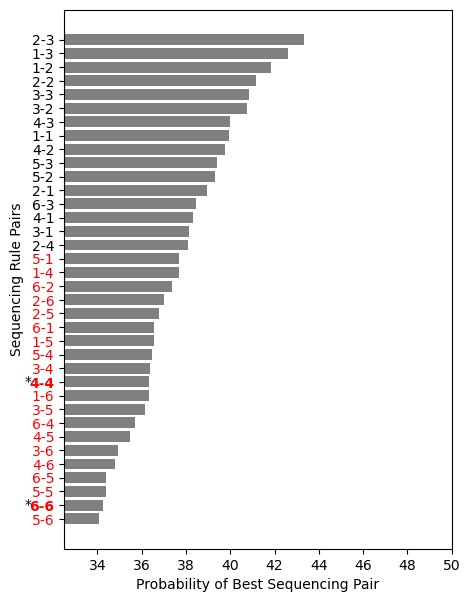

In [359]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Group to find minimum per problem
min_relative_per_problem = df_training.groupby(['ProblemSet', 'ProblemNumber'])['obj_value_relative_percent'].transform('min')

# Filter rows matching minimum
min_pairs_pandas = df_training[df_training['obj_value_relative_percent'] == min_relative_per_problem]

# Group results by problem and count singleton occurrences
result_pandas = min_pairs_pandas.groupby(['ProblemSet', 'ProblemNumber'])['Sequencing_rule'].apply(list).to_dict()

# Identify singleton pairs
singleton_pairs = {pair for pairs in result_pandas.values() if len(pairs) == 1 for pair in pairs}

# Count occurrences of each sequence pair
sequence_counts = Counter(pair for pairs in result_pandas.values() for pair in pairs)

# Convert counts to percentages
total_problems = len(result_pandas)
sequence_percentages = {pair: (count / total_problems) * 100 for pair, count in sequence_counts.items()}

# Sort pairs by frequency (descending) and extract sorted pairs and percentages
sorted_sequence_percentages = dict(sorted(sequence_percentages.items(), key=lambda item: item[1], reverse=True))
pairs = list(sorted_sequence_percentages.keys())
percentages = list(sorted_sequence_percentages.values())

# Convert pairs to strings for plotting
pairs_as_strings = [f"{p[0]}-{p[1]}" for p in pairs]

# Sort pairs and percentages in ascending order by percentage
sorted_pairs_percentages = sorted(zip(percentages, pairs_as_strings, pairs))
sorted_percentages, sorted_pairs_as_strings, sorted_pairs = zip(*sorted_pairs_percentages)

# Set threshold for bottom 20%
threshold = sorted(sorted_percentages)[int(len(sorted_percentages) * 0.5)]

# Plot
fig, ax = plt.subplots(figsize=(5, 7))  # Adjust figure size as needed

# Plot grey bars
bars = ax.barh(sorted_pairs_as_strings, sorted_percentages, color='grey')

# Apply red color to labels below the threshold and bold singleton pairs
for i, (perc, pair_str, pair) in enumerate(zip(sorted_percentages, sorted_pairs_as_strings, sorted_pairs)):
    # Check if the pair is in the bottom 20%
    if perc <= threshold:
        ax.get_yticklabels()[i].set_color("red")
    
    # Highlight pairs that have never been sole optimal
    if pair not in singleton_pairs:
        ax.get_yticklabels()[i].set_fontweight("bold")  # Bold the label
        ax.text(31, i, '*', va='center', ha='right', color='black')  # Place the star near the start of the bar
        
# Set labels and axis limits
ax.set_xlabel("Probability of Best Sequencing Pair")
ax.set_ylabel("Sequencing Rule Pairs")
ax.set_xlim(32.5, 50)  # Set x-axis range between 30 and 50

plt.show()


In [360]:
sorted_sequence_percentages

{(2, 3): 43.30769230769231,
 (1, 3): 42.61538461538461,
 (1, 2): 41.84615384615385,
 (2, 2): 41.15384615384615,
 (3, 3): 40.84615384615385,
 (3, 2): 40.76923076923077,
 (4, 3): 40.0,
 (1, 1): 39.92307692307692,
 (4, 2): 39.76923076923077,
 (5, 3): 39.38461538461539,
 (5, 2): 39.30769230769231,
 (2, 1): 38.92307692307692,
 (6, 3): 38.46153846153847,
 (4, 1): 38.30769230769231,
 (3, 1): 38.15384615384615,
 (2, 4): 38.07692307692307,
 (1, 4): 37.69230769230769,
 (5, 1): 37.69230769230769,
 (6, 2): 37.38461538461538,
 (2, 6): 37.0,
 (2, 5): 36.769230769230774,
 (1, 5): 36.53846153846153,
 (6, 1): 36.53846153846153,
 (5, 4): 36.46153846153846,
 (3, 4): 36.38461538461538,
 (1, 6): 36.30769230769231,
 (4, 4): 36.30769230769231,
 (3, 5): 36.15384615384615,
 (6, 4): 35.69230769230769,
 (4, 5): 35.46153846153846,
 (3, 6): 34.92307692307692,
 (4, 6): 34.76923076923077,
 (5, 5): 34.38461538461539,
 (6, 5): 34.38461538461539,
 (6, 6): 34.23076923076923,
 (5, 6): 34.07692307692308}

In [361]:
# Deadweight sequence pairs that NEVER were at the top by themselves and underperformed
#target_tuples = [(1, 6), (2, 4), (6, 6)]
target_tuples = [(4, 4), (6, 6)]
df_training['Deadweight'] = df_training['Sequencing_rule'].isin(target_tuples)
df_training

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds,obj_value_traditional,obj_value_relative_percent,Deadweight
0,10,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22,False
1,10,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22,False
2,10,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22,False
3,10,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22,False
4,10,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 425, 'avg_makespan': 423.0, ...",425,423.0,424.00,0.06,483.00,-12.22,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT,"(6, 2)","{'max_flow_time': 3065, 'avg_makespan': 3033.0...",3065,3033.0,3049.00,0.92,2911.25,4.73,False
46796,75,100,33,AI_LPT,"(6, 3)","{'max_flow_time': 3066, 'avg_makespan': 2908.0...",3066,2908.0,2987.00,0.95,2911.25,2.60,False
46797,75,100,34,AI_LPT,"(6, 4)","{'max_flow_time': 3076, 'avg_makespan': 3007.0...",3076,3007.0,3041.50,0.62,2911.25,4.47,False
46798,75,100,35,AI_LPT,"(6, 5)","{'max_flow_time': 3118, 'avg_makespan': 2979.5...",3118,2979.5,3048.75,0.58,2911.25,4.72,False


In [362]:
sorted_sequence_percentages

{(2, 3): 43.30769230769231,
 (1, 3): 42.61538461538461,
 (1, 2): 41.84615384615385,
 (2, 2): 41.15384615384615,
 (3, 3): 40.84615384615385,
 (3, 2): 40.76923076923077,
 (4, 3): 40.0,
 (1, 1): 39.92307692307692,
 (4, 2): 39.76923076923077,
 (5, 3): 39.38461538461539,
 (5, 2): 39.30769230769231,
 (2, 1): 38.92307692307692,
 (6, 3): 38.46153846153847,
 (4, 1): 38.30769230769231,
 (3, 1): 38.15384615384615,
 (2, 4): 38.07692307692307,
 (1, 4): 37.69230769230769,
 (5, 1): 37.69230769230769,
 (6, 2): 37.38461538461538,
 (2, 6): 37.0,
 (2, 5): 36.769230769230774,
 (1, 5): 36.53846153846153,
 (6, 1): 36.53846153846153,
 (5, 4): 36.46153846153846,
 (3, 4): 36.38461538461538,
 (1, 6): 36.30769230769231,
 (4, 4): 36.30769230769231,
 (3, 5): 36.15384615384615,
 (6, 4): 35.69230769230769,
 (4, 5): 35.46153846153846,
 (3, 6): 34.92307692307692,
 (4, 6): 34.76923076923077,
 (5, 5): 34.38461538461539,
 (6, 5): 34.38461538461539,
 (6, 6): 34.23076923076923,
 (5, 6): 34.07692307692308}

In [363]:
target_tuples

[(4, 4), (6, 6)]

In [364]:
# Copy the original dict
sequence_pairings_ranking = sorted_sequence_percentages.copy()

# Update target tuples to zero
for target in target_tuples:
    sequence_pairings_ranking[target] = 0

sequence_pairings_ranking


{(2, 3): 43.30769230769231,
 (1, 3): 42.61538461538461,
 (1, 2): 41.84615384615385,
 (2, 2): 41.15384615384615,
 (3, 3): 40.84615384615385,
 (3, 2): 40.76923076923077,
 (4, 3): 40.0,
 (1, 1): 39.92307692307692,
 (4, 2): 39.76923076923077,
 (5, 3): 39.38461538461539,
 (5, 2): 39.30769230769231,
 (2, 1): 38.92307692307692,
 (6, 3): 38.46153846153847,
 (4, 1): 38.30769230769231,
 (3, 1): 38.15384615384615,
 (2, 4): 38.07692307692307,
 (1, 4): 37.69230769230769,
 (5, 1): 37.69230769230769,
 (6, 2): 37.38461538461538,
 (2, 6): 37.0,
 (2, 5): 36.769230769230774,
 (1, 5): 36.53846153846153,
 (6, 1): 36.53846153846153,
 (5, 4): 36.46153846153846,
 (3, 4): 36.38461538461538,
 (1, 6): 36.30769230769231,
 (4, 4): 0,
 (3, 5): 36.15384615384615,
 (6, 4): 35.69230769230769,
 (4, 5): 35.46153846153846,
 (3, 6): 34.92307692307692,
 (4, 6): 34.76923076923077,
 (5, 5): 34.38461538461539,
 (6, 5): 34.38461538461539,
 (6, 6): 0,
 (5, 6): 34.07692307692308}

In [365]:
import pickle
filename = 'sequence_pairings_ranking.pkl'

# open file to write
with open(filename, 'wb') as file:
    pickle.dump(sequence_pairings_ranking, file)  # save dictionary

# Marking deadweights further
df_training['Sequencing_rule_best_pairings'] = df_training['Sequencing_rule'].map(sequence_pairings_ranking)  # map values

df_training.to_pickle(f'df_training_AI_LPT.pkl')

In [288]:
# with open(filename, 'rb') as file:
#     test = pickle.load(file)  # load dictionary
# test

#### aggregating stats from a test problem

In [382]:
# underperformers, but maybe have selective use, could be useful model selection criteria
redlisted_tuples = [
    (4, 6), (3, 4), (2, 1), (2, 6), (5, 4), (4, 5), 
    (3, 6), (3, 5), (6, 2), (1, 5), (6, 1), (5, 6), 
    (5, 5), (2, 5), (6, 4), (6, 5)
]

# Create a 'BottomPerformer' column
df_training['NicheOrBottomPerformers'] = df_training['Sequencing_rule'].isin(redlisted_tuples)
df_training


,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,max_flow_time,avg_makespan,obj_value,runtime_seconds,AggregateSolutionData,obj_value_traditional,obj_value_relative_percent,Deadweight,NicheOrBottomPerformers
0,10,1,1,AI_LPT_training,"(1, 1)",425,423.0,424.00,0.09,"{'max_flow_time': 425, 'avg_makespan': 423.0, ...",482.00,-12.03,False,False
1,10,1,2,AI_LPT_training,"(1, 2)",511,489.0,500.00,0.08,"{'max_flow_time': 511, 'avg_makespan': 489.0, ...",482.00,3.73,False,False
2,10,1,3,AI_LPT_training,"(1, 3)",425,423.0,424.00,0.06,"{'max_flow_time': 425, 'avg_makespan': 423.0, ...",482.00,-12.03,False,False
3,10,1,4,AI_LPT_training,"(1, 4)",425,423.0,424.00,0.09,"{'max_flow_time': 425, 'avg_makespan': 423.0, ...",482.00,-12.03,False,False
4,10,1,5,AI_LPT_training,"(1, 5)",425,423.0,424.00,0.09,"{'max_flow_time': 425, 'avg_makespan': 423.0, ...",482.00,-12.03,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46795,75,100,32,AI_LPT_training,"(6, 2)",3106,3050.0,3078.00,0.76,"{'max_flow_time': 3106, 'avg_makespan': 3050.0...",2921.75,5.35,False,True
46796,75,100,33,AI_LPT_training,"(6, 3)",3064,2909.0,2986.50,0.74,"{'max_flow_time': 3064, 'avg_makespan': 2909.0...",2921.75,2.22,False,False
46797,75,100,34,AI_LPT_training,"(6, 4)",3074,3008.0,3041.00,0.75,"{'max_flow_time': 3074, 'avg_makespan': 3008.0...",2921.75,4.08,False,True
46798,75,100,35,AI_LPT_training,"(6, 5)",3122,2980.5,3051.25,0.65,"{'max_flow_time': 3122, 'avg_makespan': 2980.5...",2921.75,4.43,False,True


In [461]:
def process_job_data(file_path):
    '''
    Provided a file_path str, aggregate the job dataframe for all pertinent facts that can be used as potential features for machine learning.
    It tends to leave as dict some features so that they can be broken up inside the dataframe all as one operation
    '''
    df = pd.read_pickle(file_path)
    queue_size = len(df)
    
    # Set big M to NaN
    big_m_threshold = 10000
    df[['Machine1_ProcessMinutes', 'Machine2_ProcessMinutes']] = df[['Machine1_ProcessMinutes', 'Machine2_ProcessMinutes']].map(
        lambda x: np.nan if x == big_m_threshold else x
    )

    # Cluster proportions
    clusters, cluster_counts = np.unique(df['Recipe_Cluster'], return_counts=True)
    aggregated_data = {}

    aggregated_data['proportion_jobs_per_cluster'] = {cluster: np.round(count / queue_size, 2) for cluster, count in zip(clusters, cluster_counts)}
    aggregated_data['proportion_jobs_at_queue_0'] = {cluster: np.round(len(df[(df['Recipe_Cluster'] == cluster) & (df['Queue_Step'] == 0)]) / queue_size, 2) for cluster in clusters}
    aggregated_data['proportion_jobs_at_queue_1_plus'] = {
        cluster: np.round((len(df[(df['Recipe_Cluster'] == cluster)]) - 
                           len(df[(df['Recipe_Cluster'] == cluster) & (df['Queue_Step'] == 0)])) 
                          / queue_size, 2) 
        for cluster in clusters
    }

    # Risk metrics
    aggregated_data['proportion_short_expiring_jobs'] = np.round((df['b'] < 1000).sum() / queue_size, 2)
    aggregated_data['std_queue_steps'] = np.round(np.nanstd(df['Queue_Step'].values), 2)
    aggregated_data['avg_a_values'] = np.round(np.nanmean(df['a'].values), 2)

    # Traffic intensity
    expected_arrival_rate = queue_size / (df['a'].max())
    service_rate = 1 / np.nanmean([df['Machine1_ProcessMinutes'], df['Machine2_ProcessMinutes']])
    aggregated_data['overall_traffic_intensity'] = np.round(expected_arrival_rate / service_rate, 2)
    aggregated_data['machine_specific_traffic_intensity'] = {
        'Machine1': np.round(expected_arrival_rate / (1 / np.nanmean(df['Machine1_ProcessMinutes'])), 2),
        'Machine2': np.round(expected_arrival_rate / (1 / np.nanmean(df['Machine2_ProcessMinutes'])), 2)
    }

    # Remaining workload
    aggregated_data['total_remaining_minutes'] = np.round(np.nansum(df['Remaining_Minutes'].values), 2)
    aggregated_data['remaining_minutes_per_machine'] = {
        'Machine1': np.round(df.iloc[0]['Remaining_Minutes'], 2),
        'Machine2': np.round(df.iloc[1]['Remaining_Minutes'], 2)
    }

    # Incapable jobs per machine
    aggregated_data['proportion_incapable_jobs_per_machine'] = {
        'Machine1': {cluster: np.round(df[(df['Recipe_Cluster'] == cluster) & df['Machine1_ProcessMinutes'].isna()].shape[0] / queue_size, 2) for cluster in clusters},
        'Machine2': {cluster: np.round(df[(df['Recipe_Cluster'] == cluster) & df['Machine2_ProcessMinutes'].isna()].shape[0] / queue_size, 2) for cluster in clusters}
    }

    # Current job clusters
    job_1_cluster = df['Recipe_Cluster'].iloc[0]  # First row for Machine1
    job_2_cluster = df['Recipe_Cluster'].iloc[1] # Second row for Machine2
    
    # Debug print for current job clusters
    #print("[DEBUG] Current job clusters - Machine1:", job_1_cluster, ", Machine2:", job_2_cluster)
    #display(df)
    
    aggregated_data['current_job_clusters'] = {'Machine1': job_1_cluster, 'Machine2': job_2_cluster}

    # Normalized processing time
    aggregated_data['norm_processing_time_per_cluster'] = {
        cluster: np.round(np.nansum(df[df['Recipe_Cluster'] == cluster]['Machine1_ProcessMinutes']) / queue_size, 2)
        for cluster in clusters
    }
    aggregated_data['avg_processing_time'] = np.round(np.nanmean([df['Machine1_ProcessMinutes'], df['Machine2_ProcessMinutes']]), 2)

    # Queue metrics
    aggregated_data['proportion_current_queue_vs_total'] = np.round(np.nansum(df['Queue_Step'] == 0) / queue_size, 2)

    # Processing time by queue position
    aggregated_data['norm_processing_time_by_queue_pos'] = {
        'Queue_0': np.round(np.nansum(df[df['Queue_Step'] == 0]['Machine1_ProcessMinutes']) / queue_size, 2),
        'Queue_1_plus': np.round(np.nansum(df[df['Queue_Step'] > 0]['Machine1_ProcessMinutes']) / queue_size, 2)
    }
    aggregated_data['avg_time_window'] = np.round(np.nansum(df['b'] - df['a']) / queue_size, 2)
    aggregated_data['std_time_window'] = np.round(np.nanstd(df['b'] - df['a']) / queue_size, 2)

    # Output result
    return expand_dict_columns(pd.DataFrame([aggregated_data]))

def expand_dict_columns(df, parent_key=''):
    """
    Recursively expands dictionary columns in a DataFrame. It is better than fixing a specific amount of levels, say, two (in case we want more levels of depth)
    
    Parameters:
    - df (pd.DataFrame): The DataFrame with dict columns to expand.
    - parent_key (str): Used for recursive calls; leave empty for the top-level calls.
    
    Returns:
    - pd.DataFrame: A DataFrame with all dict columns expanded into separate columns, 
      with nested keys suffixed to the parent column name.
    """
    for col in df.columns: # Full column name with parent prefix
        col_full = f"{parent_key}_{col}" if parent_key else col
        
       
        if isinstance(df[col].iloc[0], dict):  # if column's value is dict type: Expand dict column
            expanded = pd.json_normalize(df[col])
            expanded.columns = [f"{col_full}_{k}" for k in expanded.columns]
            
            # Drop original col and join expanded
            df = df.drop(columns=[col]).join(expand_dict_columns(expanded, col_full))
    
    return df.reset_index(drop=True)

# Queue Size and Problem Number Example 
QueueSize, ProblemNumber = 25,	273

file_path = f"ProblemSets/Training_Queue{QueueSize}/Problem_{ProblemNumber}_jobs.pkl"
result_df = process_job_data(file_path)
result_df.T


,Job,Recipe_Cluster,Recipe,Machine1_ProcessMinutes,Machine2_ProcessMinutes,Remaining_Minutes,Queue_Step,a,b,a_true,b_true,Machine1_ProcessUnitsPerMinute,Units,Machine2_ProcessUnitsPerMinute
0,1,B,9,107.0,27.0,15.0,0,0,3500,0,3500,1,107,4
1,2,D,4,NaN,39.0,0.0,0,0,3500,0,3500,0,116,3
2,3,D,17,218.0,109.0,NaN,0,0,1450,0,1450,1,218,2
3,4,C,5,9.0,9.0,NaN,0,0,1550,0,1550,5,43,5
4,5,C,3,70.0,NaN,NaN,0,0,1525,0,1525,1,70,0
5,6,D,17,36.0,18.0,NaN,0,0,1450,0,1450,1,36,2
6,7,B,20,9.0,4.0,NaN,0,0,3500,0,3500,3,26,6
7,8,C,14,27.0,33.0,NaN,1,60,3560,50,3550,6,163,5
8,9,C,2,136.0,136.0,NaN,1,60,3560,50,3550,1,136,1
9,10,C,7,57.0,24.0,NaN,1,60,1585,60,1585,3,170,7


,0
proportion_short_expiring_jobs,0.04
std_queue_steps,1.27
avg_a_values,141.84
overall_traffic_intensity,2.66
total_remaining_minutes,15.0
avg_processing_time,60.16
proportion_current_queue_vs_total,0.28
avg_time_window,2135.6
std_time_window,42.29
proportion_jobs_per_cluster_B,0.12


In [452]:
df_base

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,10,1,1,Traditional_LPT,None,"{'max_flow_time': 511, 'avg_makespan': 453.0, ...",511,453.0,482.00,0.04
1,10,2,1,Traditional_LPT,None,"{'max_flow_time': 620, 'avg_makespan': 412.5, ...",620,412.5,516.25,0.06
2,10,3,1,Traditional_LPT,None,"{'max_flow_time': 715, 'avg_makespan': 386.5, ...",715,386.5,550.75,0.06
3,10,4,1,Traditional_LPT,None,"{'max_flow_time': 637, 'avg_makespan': 305.0, ...",637,305.0,471.00,0.05
4,10,5,1,Traditional_LPT,None,"{'max_flow_time': 773, 'avg_makespan': 339.0, ...",773,339.0,556.00,0.06
...,...,...,...,...,...,...,...,...,...,...
1295,75,96,1,Traditional_LPT,None,"{'max_flow_time': 2709, 'avg_makespan': 2599.5...",2709,2599.5,2654.25,1.43
1296,75,97,1,Traditional_LPT,None,"{'max_flow_time': 2485, 'avg_makespan': 2472.5...",2485,2472.5,2478.75,1.43
1297,75,98,1,Traditional_LPT,None,"{'max_flow_time': 2556, 'avg_makespan': 2543.0...",2556,2543.0,2549.50,1.36
1298,75,99,1,Traditional_LPT,None,"{'max_flow_time': 3109, 'avg_makespan': 2976.0...",3109,2976.0,3042.50,1.24


In [491]:

def process_job_wrapper(args):
    """
    Process job data and expand nested dictionary fields.
    """
    problem_set, problem_number, prefix = args
    file_path = f"ProblemSets/{prefix}Queue{problem_set}/Problem_{problem_number}_jobs.pkl"
    
    result_df = process_job_data(file_path)
    
    if result_df is not None: # Add metadata if the result is valid
        result_df['ProblemSet'] = problem_set
        result_df['ProblemNumber'] = problem_number
    
    return result_df

def main_multiprocessing(df_base, prefix="Training_"):
    """
    Process all job combinations in parallel and concatenate results.
    """
    problem_pairs = [(row['ProblemSet'], row['ProblemNumber'], prefix) for _, row in df_base.iterrows()]
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1) as pool:
        results = list(tqdm(pool.imap(process_job_wrapper, 
                                      problem_pairs), 
                            total=len(problem_pairs), desc="Processing Jobs"))

    # Filter valid DataFrames and concatenate
    valid_results = [res for res in results if res is not None]
    aggregated_df = pd.concat(valid_results, ignore_index=True) if valid_results else pd.DataFrame()
    
    return aggregated_df

if __name__ == "__main__":   
    
    # Process jobs
    prefix = "Training_"
    processed_df = main_multiprocessing(df_base, 
                                        prefix=prefix)

    ### Because all NaNs indicate clusters that did NOT appear, use na fill to 0!!!
    processed_df = processed_df.fillna(0)

    # Display results
    display(processed_df.head())
    # processed_df.to_pickle('aggregated_results.pkl')

Processing Jobs: 100%|█████████████████████████████████████████████████████████████| 1300/1300 [00:04<00:00, 308.25it/s]


,proportion_short_expiring_jobs,std_queue_steps,avg_a_values,overall_traffic_intensity,total_remaining_minutes,avg_processing_time,proportion_current_queue_vs_total,avg_time_window,std_time_window,proportion_jobs_per_cluster_A,...,current_job_clusters_Machine1,current_job_clusters_Machine2,norm_processing_time_per_cluster_A,norm_processing_time_per_cluster_B,norm_processing_time_per_cluster_C,norm_processing_time_per_cluster_D,norm_processing_time_by_queue_pos_Queue_0,norm_processing_time_by_queue_pos_Queue_1_plus,ProblemSet,ProblemNumber
0,0.2,1.00,81.3,1.25,40.0,41.94,0.4,2302.5,124.76,0.2,...,D,D,14.4,4.2,0.8,23.6,13.3,29.7,10,1
1,0.2,0.70,59.8,4.64,55.0,69.07,0.3,2307.5,124.44,0.2,...,C,A,0.6,0.0,28.7,8.7,25.4,12.6,10,2
2,0.2,1.14,101.4,0.92,20.0,52.00,0.3,2107.5,119.66,0.2,...,D,D,10.3,4.8,21.9,15.2,13.3,38.9,10,3
3,0.1,1.35,131.8,0.62,45.0,34.81,0.4,2800.0,110.01,0.0,...,C,C,0.0,14.6,4.8,20.2,13.5,26.1,10,4
4,0.0,1.28,155.6,0.85,0.0,48.00,0.3,2297.5,98.23,0.3,...,C,D,13.3,7.0,12.0,21.8,30.3,23.8,10,5


In [492]:
### PASSES UNIT TEST - Empty sets

# # Check for missing values
# null_rows_mask = processed_df.isnull().any(axis=1)  # Mask for any null

# # Filter rows with nulls
# rows_with_nulls = processed_df[null_rows_mask]  # Rows with missing values

# # Display rows with nulls
# display(rows_with_nulls)

# # Summarize missing values
# missing_values_summary = processed_df.isnull().sum()  # Count missing per column

# # Display columns with missing values
# print("\n[DEBUG] Summary of missing values by column:")
# missing_values_summary[missing_values_summary > 0]  # Show only non-zero counts


In [510]:
# Tidying data
columns_to_drop = [
    'Algorithm',
    'SolutionNumber',
    'max_flow_time', 
    'avg_makespan', 
    'obj_value', 
    'runtime_seconds', 
    'AggregateSolutionData', 
    'obj_value_traditional'
]

# Drop columns
df_training_tidy = df_training.drop(columns=columns_to_drop)

# Filter rows then drop deadweight
df_training_tidy = df_training_tidy[~df_training_tidy['Deadweight']].drop(columns=['Deadweight']).reset_index(drop=True)

# Convert ProblemSet to integer and rename
df_training_tidy['QueueSize'] = df_training_tidy['ProblemSet'].astype(int)

# display(df_training_tidy)

## Merging most of the X on
df_training_tidy = pd.merge(df_training_tidy, 
                            processed_df,
                            on=['ProblemSet', 'ProblemNumber'],
                            how='inner'
                            )
# Convert to int
df_training_tidy['ProblemSet'] = df_training_tidy['ProblemSet'].astype(int) 
df_training_tidy['ProblemNumber'] = df_training_tidy['ProblemNumber'].astype(int) 

## drop these after merge
#df_training_tidy.drop(columns=['ProblemSet','ProblemNumber'], inplace = True) ## NEED THEM FOR OBJECTIVE VALUE
display(df_training_tidy)

##############################################
#### Need to use label encoding to ensure machine learning handles categoricals
from sklearn.preprocessing import LabelEncoder  # Label encoding

# Get categorical columns
categorical_cols = df_training_tidy.select_dtypes(include=['object']).columns[1:] # skip the y column with sequence pairings

# Encode columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()  # Encoder
    df_training_tidy[col] = le.fit_transform(df_training_tidy[col])
    label_encoders[col] = le  # Store encoder

# Verify
print("[DEBUG] Encoded categorical columns:")
display(df_training_tidy[categorical_cols])

####################################
## Need to get the minimum objective value per grouping of Problem Set and Problem Number

# Group by ProblemSet and ProblemNumber
min_pairs_aggregate = df_training_tidy.groupby(['ProblemSet', 
                                                'ProblemNumber'], 
                                               as_index=False)[
    'obj_value_relative_percent'].min()  # Get minimum per group

# Display result
display(min_pairs_aggregate)

# Rename column to indicate best score
min_pairs_aggregate = min_pairs_aggregate.rename(columns={'obj_value_relative_percent': 'best_obj_value_relative_percent'})

# Merge with the original DataFrame on ProblemSet and ProblemNumber
df_training_tidy = df_training_tidy.merge(min_pairs_aggregate, 
                                          on=['ProblemSet', 'ProblemNumber'], 
                                          how='left')

df_training_tidy.drop(columns=['ProblemSet', 'ProblemNumber'], inplace=True)
display(df_training_tidy)


,ProblemSet,ProblemNumber,Sequencing_rule,obj_value_relative_percent,NicheOrBottomPerformers,QueueSize,proportion_short_expiring_jobs,std_queue_steps,avg_a_values,overall_traffic_intensity,...,proportion_incapable_jobs_per_machine_Machine2.C,proportion_incapable_jobs_per_machine_Machine2.D,current_job_clusters_Machine1,current_job_clusters_Machine2,norm_processing_time_per_cluster_A,norm_processing_time_per_cluster_B,norm_processing_time_per_cluster_C,norm_processing_time_per_cluster_D,norm_processing_time_by_queue_pos_Queue_0,norm_processing_time_by_queue_pos_Queue_1_plus
0,10,1,"(1, 1)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.00,0.20,D,D,14.40,4.20,0.80,23.60,13.30,29.70
1,10,1,"(1, 2)",3.73,False,10,0.20,1.00,81.30,1.25,...,0.00,0.20,D,D,14.40,4.20,0.80,23.60,13.30,29.70
2,10,1,"(1, 3)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.00,0.20,D,D,14.40,4.20,0.80,23.60,13.30,29.70
3,10,1,"(1, 4)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.00,0.20,D,D,14.40,4.20,0.80,23.60,13.30,29.70
4,10,1,"(1, 5)",-12.03,True,10,0.20,1.00,81.30,1.25,...,0.00,0.20,D,D,14.40,4.20,0.80,23.60,13.30,29.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,75,100,"(6, 1)",6.57,True,75,0.11,1.21,156.84,8.52,...,0.12,0.13,A,D,5.33,4.59,21.83,21.83,8.33,45.24
42896,75,100,"(6, 2)",5.35,True,75,0.11,1.21,156.84,8.52,...,0.12,0.13,A,D,5.33,4.59,21.83,21.83,8.33,45.24
42897,75,100,"(6, 3)",2.22,False,75,0.11,1.21,156.84,8.52,...,0.12,0.13,A,D,5.33,4.59,21.83,21.83,8.33,45.24
42898,75,100,"(6, 4)",4.08,True,75,0.11,1.21,156.84,8.52,...,0.12,0.13,A,D,5.33,4.59,21.83,21.83,8.33,45.24


[DEBUG] Encoded categorical columns:


,current_job_clusters_Machine1,current_job_clusters_Machine2
0,3,3
1,3,3
2,3,3
3,3,3
4,3,3
...,...,...
42895,0,3
42896,0,3
42897,0,3
42898,0,3


,ProblemSet,ProblemNumber,obj_value_relative_percent
0,10,1,-12.03
1,10,2,-9.30
2,10,3,-2.50
3,10,4,0.00
4,10,5,0.00
...,...,...,...
1295,75,96,0.00
1296,75,97,0.39
1297,75,98,-6.19
1298,75,99,-3.16


,Sequencing_rule,obj_value_relative_percent,NicheOrBottomPerformers,QueueSize,proportion_short_expiring_jobs,std_queue_steps,avg_a_values,overall_traffic_intensity,total_remaining_minutes,avg_processing_time,...,proportion_incapable_jobs_per_machine_Machine2.D,current_job_clusters_Machine1,current_job_clusters_Machine2,norm_processing_time_per_cluster_A,norm_processing_time_per_cluster_B,norm_processing_time_per_cluster_C,norm_processing_time_per_cluster_D,norm_processing_time_by_queue_pos_Queue_0,norm_processing_time_by_queue_pos_Queue_1_plus,best_obj_value_relative_percent
0,"(1, 1)",-12.03,False,10,0.20,1.00,81.30,1.25,40.0,41.94,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
1,"(1, 2)",3.73,False,10,0.20,1.00,81.30,1.25,40.0,41.94,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
2,"(1, 3)",-12.03,False,10,0.20,1.00,81.30,1.25,40.0,41.94,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
3,"(1, 4)",-12.03,False,10,0.20,1.00,81.30,1.25,40.0,41.94,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
4,"(1, 5)",-12.03,True,10,0.20,1.00,81.30,1.25,40.0,41.94,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,"(6, 1)",6.57,True,75,0.11,1.21,156.84,8.52,25.0,64.20,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42896,"(6, 2)",5.35,True,75,0.11,1.21,156.84,8.52,25.0,64.20,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42897,"(6, 3)",2.22,False,75,0.11,1.21,156.84,8.52,25.0,64.20,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42898,"(6, 4)",4.08,True,75,0.11,1.21,156.84,8.52,25.0,64.20,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67


In [1]:
display(df_training_tidy.T)

NameError: name 'df_training_tidy' is not defined

In [507]:
df_training_tidy

,ProblemSet,ProblemNumber,Sequencing_rule,obj_value_relative_percent,NicheOrBottomPerformers,QueueSize,proportion_short_expiring_jobs,std_queue_steps,avg_a_values,overall_traffic_intensity,...,proportion_incapable_jobs_per_machine_Machine2.D,current_job_clusters_Machine1,current_job_clusters_Machine2,norm_processing_time_per_cluster_A,norm_processing_time_per_cluster_B,norm_processing_time_per_cluster_C,norm_processing_time_per_cluster_D,norm_processing_time_by_queue_pos_Queue_0,norm_processing_time_by_queue_pos_Queue_1_plus,best_obj_value_relative_percent
0,10,1,"(1, 1)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
1,10,1,"(1, 2)",3.73,False,10,0.20,1.00,81.30,1.25,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
2,10,1,"(1, 3)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
3,10,1,"(1, 4)",-12.03,False,10,0.20,1.00,81.30,1.25,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
4,10,1,"(1, 5)",-12.03,True,10,0.20,1.00,81.30,1.25,...,0.20,3,3,14.40,4.20,0.80,23.60,13.30,29.70,-12.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,75,100,"(6, 1)",6.57,True,75,0.11,1.21,156.84,8.52,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42896,75,100,"(6, 2)",5.35,True,75,0.11,1.21,156.84,8.52,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42897,75,100,"(6, 3)",2.22,False,75,0.11,1.21,156.84,8.52,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67
42898,75,100,"(6, 4)",4.08,True,75,0.11,1.21,156.84,8.52,...,0.13,0,3,5.33,4.59,21.83,21.83,8.33,45.24,-3.67


In [498]:
categorical_cols

Index(['current_job_clusters_Machine1', 'current_job_clusters_Machine2'], dtype='object')

In [499]:
df_training_tidy.to_pickle('df_training_tidy.pkl')

In [500]:
df_training_tidy.head(33)

,ProblemSet,ProblemNumber,Sequencing_rule,obj_value_relative_percent,NicheOrBottomPerformers,QueueSize,proportion_short_expiring_jobs,std_queue_steps,avg_a_values,overall_traffic_intensity,...,proportion_incapable_jobs_per_machine_Machine2.C,proportion_incapable_jobs_per_machine_Machine2.D,current_job_clusters_Machine1,current_job_clusters_Machine2,norm_processing_time_per_cluster_A,norm_processing_time_per_cluster_B,norm_processing_time_per_cluster_C,norm_processing_time_per_cluster_D,norm_processing_time_by_queue_pos_Queue_0,norm_processing_time_by_queue_pos_Queue_1_plus
0,10,1,"(1, 1)",-12.03,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
1,10,1,"(1, 2)",3.73,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
2,10,1,"(1, 3)",-12.03,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
3,10,1,"(1, 4)",-12.03,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
4,10,1,"(1, 5)",-12.03,True,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
5,10,1,"(2, 1)",14.57,True,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
6,10,1,"(2, 2)",20.07,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
7,10,1,"(2, 3)",14.57,False,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
8,10,1,"(2, 5)",14.57,True,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7
9,10,1,"(2, 6)",20.07,True,10,0.2,1.0,81.3,1.25,...,0.0,0.2,3,3,14.4,4.2,0.8,23.6,13.3,29.7


### Machine Learning Implementation (AI_LPT)

- Need to have a way to tie-break for each ProblemSet and ProblemNumber, and to prune away the bad sequence pairs

In [366]:
df_training[(df_training['ProblemSet'] == str(QueueSize)) & 
                   (df_training['ProblemNumber'] == str(ProblemNumber)) & 
                   (df_training['Deadweight'] == False)]


,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds,obj_value_traditional,obj_value_relative_percent,Deadweight,Sequencing_rule_best_pairings
43200,75,1,1,AI_LPT,"(1, 1)","{'max_flow_time': 2375, 'avg_makespan': 2420.5...",2375,2420.5,2397.75,1.35,2481.5,-3.37,False,39.923077
43201,75,1,2,AI_LPT,"(1, 2)","{'max_flow_time': 2776, 'avg_makespan': 2594.0...",2776,2594.0,2685.00,1.51,2481.5,8.20,False,41.846154
43202,75,1,3,AI_LPT,"(1, 3)","{'max_flow_time': 2529, 'avg_makespan': 2469.0...",2529,2469.0,2499.00,1.31,2481.5,0.71,False,42.615385
43203,75,1,4,AI_LPT,"(1, 4)","{'max_flow_time': 2900, 'avg_makespan': 2686.0...",2900,2686.0,2793.00,1.54,2481.5,12.55,False,37.692308
43204,75,1,5,AI_LPT,"(1, 5)","{'max_flow_time': 2704, 'avg_makespan': 2386.0...",2704,2386.0,2545.00,1.44,2481.5,2.56,False,36.538462
43205,75,1,6,AI_LPT,"(1, 6)","{'max_flow_time': 2833, 'avg_makespan': 2782.5...",2833,2782.5,2807.75,1.59,2481.5,13.15,False,36.307692
43206,75,1,7,AI_LPT,"(2, 1)","{'max_flow_time': 2370, 'avg_makespan': 2419.0...",2370,2419.0,2394.50,1.50,2481.5,-3.51,False,38.923077
43207,75,1,8,AI_LPT,"(2, 2)","{'max_flow_time': 2776, 'avg_makespan': 2594.0...",2776,2594.0,2685.00,1.50,2481.5,8.20,False,41.153846
43208,75,1,9,AI_LPT,"(2, 3)","{'max_flow_time': 2464, 'avg_makespan': 2513.5...",2464,2513.5,2488.75,1.31,2481.5,0.29,False,43.307692
43209,75,1,10,AI_LPT,"(2, 4)","{'max_flow_time': 2865, 'avg_makespan': 2803.5...",2865,2803.5,2834.25,1.57,2481.5,14.22,False,38.076923


In [367]:
import pandas as pd
import numpy as np

def get_best_AI_LPT(QueueSize, ProblemNumber, df_path='df_training_AI_LPT.pkl'):
    """
    Gets one row from the data based on QueueSize and ProblemNumber.
    
    Filters rows by QueueSize, ProblemNumber, and Deadweight. 
    Then, it finds the row with the lowest 'obj_value_relative_percent'. 
    If there are ties, it picks the row with the highest 'Sequencing_rule_best_pairings'. If there are more ties, it grabs the first row.
    
    Parameters:
    - QueueSize (int): Queue size to filter
    - ProblemNumber (int): Problem number to filter
    - df_path (str): Path to data file (default: 'df_training_AI_LPT.pkl')

    Returns:
    - DataFrame: One filtered row
    """
    # load DataFrame
    df_training = pd.read_pickle(df_path)  # load dataframe

    # apply mask for filters
    mask = df_training[(df_training['ProblemSet'] == str(QueueSize)) & 
                       (df_training['ProblemNumber'] == str(ProblemNumber)) & 
                       (df_training['Deadweight'] == False)]

    # filter for minimum value
    min_rows = mask[np.isclose(mask['obj_value_relative_percent'].values, 
                               np.min(mask['obj_value_relative_percent'].values))]

    # filter for maximum pairing value
    final_row = min_rows[np.isclose(min_rows['Sequencing_rule_best_pairings'].values, 
                                    np.max(min_rows['Sequencing_rule_best_pairings'].values))].head(1)  # select first row

    return final_row  # return one row

# Usage example
QueueSize, ProblemNumber = 75, 1
result = get_best_AI_LPT(QueueSize, ProblemNumber)
display(result)

## Finding the SolutionNumber to use
SolutionNumber_WarmStart = result['SolutionNumber'].iloc[0]
SolutionNumber_WarmStart

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds,obj_value_traditional,obj_value_relative_percent,Deadweight,Sequencing_rule_best_pairings
43206,75,1,7,AI_LPT,"(2, 1)","{'max_flow_time': 2370, 'avg_makespan': 2419.0...",2370,2419.0,2394.5,1.5,2481.5,-3.51,False,38.923077


7

In [84]:
# - While Multivariate Decision Trees and Optimal Classification Trees were considered, neither was pursued due to more incredible difficulty in implementation. Notably, the multivariate decision trees are markedly less interpretable and less supported with heuristics than the univariate ones. However, improved metrics have been seen with the combination of the two approaches. Unfortunately, only limited time is available, so these were left tabled for the project.
# - Instead, univariate decision tree classifiers with chaining between the sequence rule predictions of machine to machine and using a custom scoring objective of the relative objective value difference in percent.


# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier  # Decision Trees for interpretability, support, and ease
# from sklearn.multioutput import ClassifierChain  # Chaining
# from skopt import BayesSearchCV  # Bayesian optimization, hyperparameter tuning
# from sklearn.model_selection import StratifiedKFold  # Stratify by QueueSize
# from sklearn.preprocessing import LabelEncoder  # For encoding tuple pairs as single labels

# # Prepare features and target with combined target for stratification
# def prepare_features(df):
#     X = df.drop(columns=['Sequencing_rule', 'obj_value_relative_percent', 'NicheOrBottomPerformers'])
    
#     # Convert 'Sequencing_rule' to tuple-based labels in y
#     y = pd.DataFrame(df['Sequencing_rule'].tolist(), columns=['Machine1', 'Machine2'])
    
#     # Create a unique identifier for each row in y by combining 'Machine1' and 'Machine2' as strings
#     y_combined = y['Machine1'].astype(str) + '-' + y['Machine2'].astype(str)
    
#     # Encode the combined string as single labels for stratification
#     label_encoder = LabelEncoder()
#     y_combined_encoded = label_encoder.fit_transform(y_combined)  # Encode combined labels

#     # Debug: Check for categorical columns in X
#     categorical_cols = X.select_dtypes(include=['object', 'category']).columns
#     print("Categorical columns in X:", categorical_cols.tolist())
#     print("Sample values in categorical columns:")
#     for col in categorical_cols:
#         print(f"{col}: {X[col].unique()[:5]}")  # Print up to 5 unique values for each categorical column

#     return X, y, y_combined_encoded  # Return the encoded labels for stratified k-fold, and keep y for prediction


# # Define model with chaining
# def create_chain_model(base_estimator):
#     chain_model = {
#         'Machine1_to_Machine2': ClassifierChain(base_estimator, order=[0, 1], random_state=0),
#         'Machine2_to_Machine1': ClassifierChain(base_estimator, order=[1, 0], random_state=0)
#     }
#     return chain_model

# # Perform BayesSearchCV optimization with combined target for stratification
# def optimize_model(chain_model, X, y, y_combined_encoded):
#     search_space = {
#         'base_estimator__max_depth': (2, 8),
#         'base_estimator__min_samples_leaf': (0, 1000),
#         'base_estimator__min_samples_split': (2, 1000)
#     }
#     strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

#     # Use BayesSearchCV for each model in chain_model
#     bayes_cv = {
#         key: BayesSearchCV(
#             model,
#             search_space,
#             cv=strat_kfold.split(X, y_combined_encoded),  # Use encoded target for stratification
#             n_iter=20,
#             random_state=0,
#             #n_jobs=-1
#         ) for key, model in chain_model.items()
#     }

#     # Fit each direction
#     for direction, model in bayes_cv.items():
#         model.fit(X, y)
#     return bayes_cv

# # Calculate custom score based on 'obj_value_relative_percent'
# def calculate_custom_score(df, predictions):
#     df['pred_Machine1'], df['pred_Machine2'] = zip(*predictions)
#     score = df['obj_value_relative_percent'].mean()  # Placeholder for custom scoring logic
#     return score

# # Main pipeline
# if __name__ == "__main__":

#     #### !@!!!!!!!!!!!!!!! NEEDS to consider 'NicheOrBottomPerformers' True OR False for four model combinations
    
#     # Load the data
#     file_path = "df_training_tidy.pkl"  # Replace with your file path
#     df = pd.read_pickle(file_path)
#     X, y, y_combined_encoded = prepare_features(df)

#     # Create base estimator and chaining model
#     base_estimator = DecisionTreeClassifier()
#     chain_model = create_chain_model(base_estimator)

#     # Perform Bayesian optimization with stratified k-fold cross-validation
#     optimized_models = optimize_model(chain_model, X, y, y_combined_encoded)

#     # Generate predictions for each direction
#     predictions = {direction: model.predict(X) for direction, model in optimized_models.items()}

#     # Calculate custom scores for each direction
#     scores = {direction: calculate_custom_score(df, predictions[direction]) for direction in predictions}

#     # Display custom scores
#     print("Custom Score for Machine1 -> Machine2:", scores['Machine1_to_Machine2'])
#     print("Custom Score for Machine2 -> Machine1:", scores['Machine2_to_Machine1'])


# Visualizations and Some Stats (Mixed Effect Models)

#### Visualizing gantt charts

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patheffects as path_effects

def seaborn_gantt_chart(
        job_tracking_df,
        title="Job Shop Gantt Chart",
        figsize=(10, 4),
        bar_height=0.25,
        fontsize_labels=12,
        fontsize_title=14,
        text_fontsize=11,
        legend=False,
        x_max=None,
        buffer=50
    ):
    """
    Gantt chart of job scheduling using Seaborn.
    
    Parameters:
        job_tracking_df (DataFrame): DataFrame containing job tracking information.
        title (str): Title for the plot.
        figsize (tuple): Size of the figure.
        bar_height (float): Height of the bars representing jobs.
        fontsize_labels (int): Font size for axis labels.
        fontsize_title (int): Font size for the plot title.
        text_fontsize (int): Font size for the job number on the bars.
        legend (bool): Whether to show legend or not.
        x_max (int or None): Maximum x-axis limit, defaults to None for automatic.
        buffer (int): Buffer space to add beyond the maximum makespan for visual clarity.
    """
    # Set color palette
    palette = sns.color_palette("colorblind")

    # Create figure and axis
    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Assign colors to jobs
    unique_jobs = sorted(job_tracking_df['Job'].unique())
    job_colors = {job: palette[i % len(palette)] for i, job in enumerate(unique_jobs)}

    # Sort data by 'Machine'
    sorted_df = job_tracking_df.sort_values(by='Machine', ascending=True)

    # Get unique machine count
    num_machines = len(sorted_df['Machine'].unique())

    # Map machine to visual index
    machine_order_mapping = {machine: idx for idx, machine in enumerate(sorted(sorted_df['Machine'].unique(), reverse=True))}

    # Plot each job
    for _, row in sorted_df.iterrows():
        if pd.notna(row['Start_Time']) and pd.notna(row['End_Time']):
            machine_mapped = machine_order_mapping[row['Machine']]
            job_color = job_colors[row['Job']]
            hatch_pattern = None

            if row['Job'] == 0:
                hatch_pattern = '//'
            elif row['Job'] <= num_machines:
                hatch_pattern = '\\'

            ax.barh(
                y=machine_mapped,
                width=row['End_Time'] - row['Start_Time'],
                left=row['Start_Time'],
                color=job_color,
                edgecolor='black',
                height=bar_height,
                hatch=hatch_pattern,
                alpha=0.85
            )

    # Calculate max makespan
    max_makespan = 0
    makespans = {}
    for machine in range(num_machines):
        makespan = sorted_df[sorted_df['Machine'] == machine]['End_Time'].max()
        makespans[machine] = makespan
        if makespan > max_makespan:
            max_makespan = makespan

    max_makespan += buffer

    # Add makespan labels
    for machine, makespan in makespans.items():
        ax.text(
            makespan,
            machine_order_mapping[machine],
            f'{int(makespan)} min',
            va='center', ha='left', fontsize=text_fontsize, fontweight='bold', color='white',
            path_effects=[path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]
        )

    # Draw gap arrow if two machines
    if num_machines == 2:
        makespan_1 = makespans[0]
        makespan_2 = makespans[1]
        gap = abs(makespan_1 - makespan_2)
        if gap > 0:
            x_min = min(makespan_1, makespan_2)
            x_max_for_arrow = max(makespan_1, makespan_2)
            y_position = (machine_order_mapping[0] + machine_order_mapping[1]) / 2

            # Draw arrow for gap
            ax.annotate(
                '', 
                xy=(x_max_for_arrow, y_position), 
                xytext=(x_min, y_position), 
                arrowprops=dict(arrowstyle='|-|,widthA=0.5,widthB=0.5', color='black', lw=1.5)
            )

            # Add gap label
            ax.text(
                x_min - 20,
                y_position,
                f'Gap: {gap} min',
                va='center', ha='right', fontsize=text_fontsize, fontweight='bold', color='white',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]
            )

    # Set labels and title
    ax.set_xlabel('Minutes', fontsize=fontsize_labels)
    ax.set_title(title, fontsize=fontsize_title)

    # Set x-axis limit
    ax.set_xlim(0, x_max if x_max is not None else max_makespan)

    # Set y-axis labels
    mapped_indices = list(machine_order_mapping.values())
    machine_labels = [f'Machine {machine + 1}' for machine in sorted(machine_order_mapping.keys(), reverse=True)]
    ax.set_yticks(mapped_indices)
    ax.set_yticklabels(machine_labels)

    # Add grid
    ax.grid(axis='x', linestyle='--', color='gray', alpha=0.6)

    # Tighten layout and show
    plt.tight_layout()
    plt.savefig(f'Visualized_Scheduling_GanttCharts{titling}.png')
    plt.show()
    

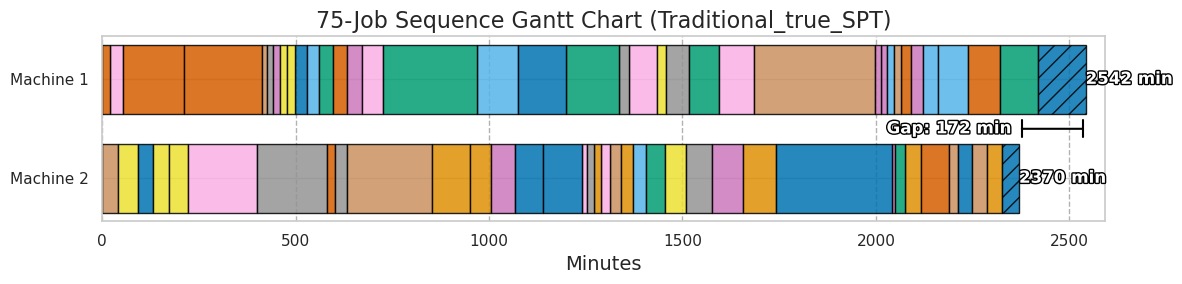

In [257]:
# Example usage
QueueSize, ProblemNumber = 75, 2
method = 'Traditional_true_SPT'
titling = f"{QueueSize}-Job Sequence Gantt Chart ({method})"
job_tracking_df = pd.read_pickle(f'ProblemSets/Training_Queue{QueueSize}/Solutions/{method}/Problem_{ProblemNumber}_Solution_1.pkl')['job_tracking_df'] # accesses dict
seaborn_gantt_chart(
    job_tracking_df,
    title=titling,
    figsize=(12, 3),
    bar_height=0.7,
    fontsize_labels=14,
    fontsize_title=16,
    text_fontsize=12,
    legend=False
)

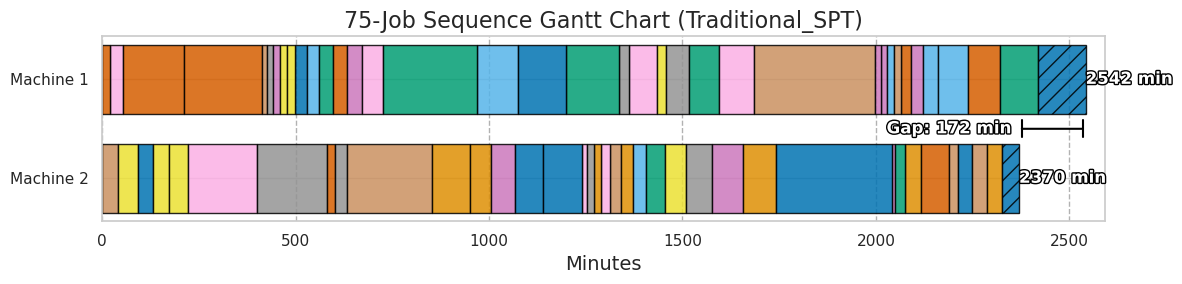

In [258]:
# Example usage
QueueSize, ProblemNumber = 75, 2
method = 'Traditional_SPT'
titling = f"{QueueSize}-Job Sequence Gantt Chart ({method})"
job_tracking_df = pd.read_pickle(f'ProblemSets/Training_Queue{QueueSize}/Solutions/{method}/Problem_{ProblemNumber}_Solution_1.pkl')['job_tracking_df'] # accesses dict
seaborn_gantt_chart(
    job_tracking_df,
    title=titling,
    figsize=(12, 3),
    bar_height=0.7,
    fontsize_labels=14,
    fontsize_title=16,
    text_fontsize=12,
    legend=False
)

#### Visualizing sequence rules

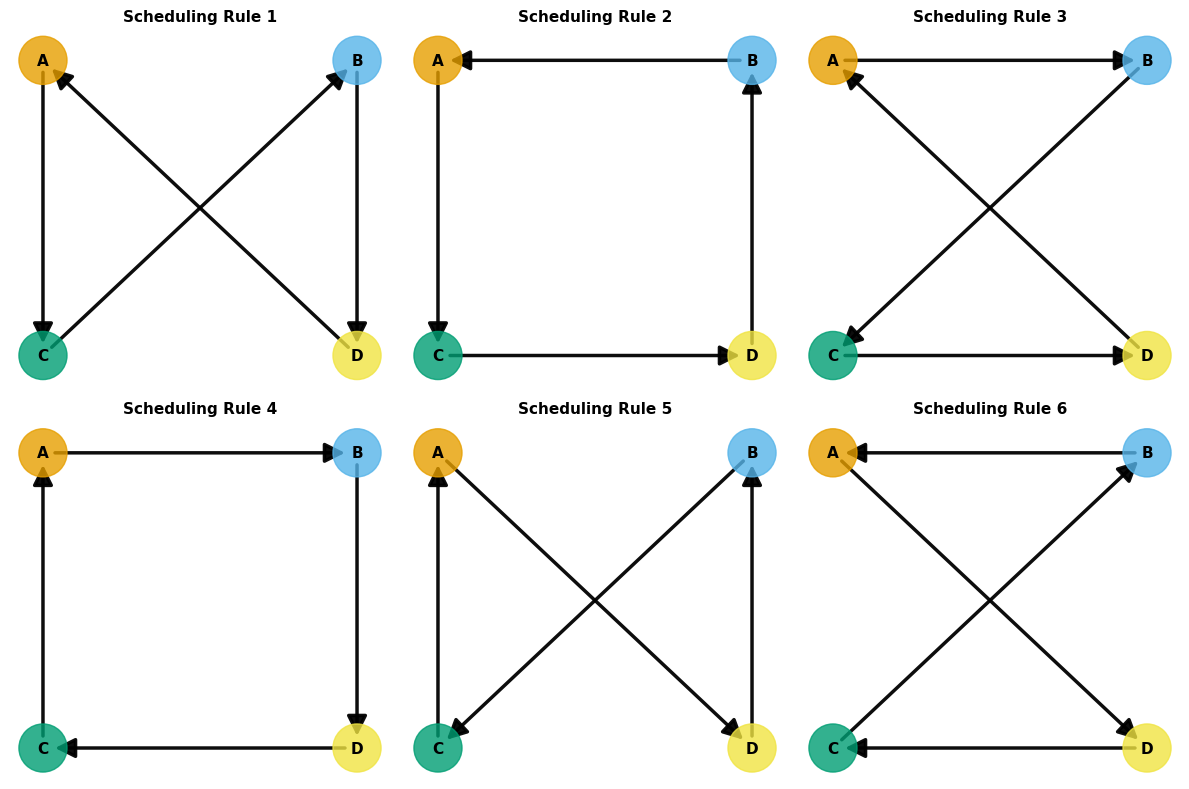

In [367]:
import networkx as nx

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
# square layout
fixed_positions = {'A': (0, 1), 'B': (1, 1), 'C': (0, 0), 'D': (1, 0)}
sequences = [
    ('A', 'C', 'B', 'D'),
    ('A', 'C', 'D', 'B'),
    ('A', 'B', 'C', 'D'),
    ('A', 'B', 'D', 'C'),
    ('A', 'D', 'B', 'C'),
    ('A', 'D', 'C', 'B')
]
# color blind friendly
node_colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442"]  # Colors for A, B, C, D

for i, sequence in enumerate(sequences):
    # Initialize graph
    G = nx.DiGraph()
    
    # Add nodes
    G.add_nodes_from(fixed_positions.keys())
    
    # Add edges
    for j in range(len(sequence) - 1):
        G.add_edge(sequence[j], sequence[j + 1], color=dark_edge_colors[i], weight=2)
    
    # Add an edge from the last to the first node
    G.add_edge(sequence[-1], sequence[0], color=dark_edge_colors[i], weight=2)
    
    # Draw graph
    edge_colors_in_sequence = [G[u][v]['color'] for u, v in G.edges()]
    nx.draw_networkx_nodes(G, fixed_positions, ax=axes[i], node_color=node_colors, node_size=1200, alpha=0.8)
    nx.draw_networkx_edges(G, fixed_positions, ax=axes[i], arrowstyle='-|>', arrowsize=30, edge_color='black', width=2.5, alpha=0.95)
    nx.draw_networkx_labels(G, fixed_positions, ax=axes[i], font_size=11, font_weight="bold")
    
    # titling and axis
    axes[i].set_title(f"Scheduling Rule {i+1}", fontweight="bold", fontsize=11)
    axes[i].axis("off")  # Turn off axis

# Adjust layout
plt.tight_layout()
#plt.show()

plt.savefig('Visualized_Scheduling_Rules.png')


In [53]:
import pandas as pd
setup_df = pd.read_pickle(f"Recipes_ProcessSetupByMachine.pkl")
setup_df

Machine1_ProcessUnitsPerMinute  \
Recipe_Cluster Recipe                                   
A              6                                    2   
               13                                   0   
               18                                   7   
B              1                                    0   
               9                                    1   
               19                                   2   
               20                                   3   
C              2                                    1   
               3                                    1   
               5                                    5   
               7                                    3   
               8                                    4   
               11                                   7   
               14                                   6   
D              4                                    0   
               10                                   8   
               12                                   2   
               15                                   2   
               16                                   3   
               17                                   1   

                       Machine2_ProcessUnitsPerMinute  Recipe_Temperatures  \
Recipe_Cluster Recipe                                                        
A              6                                    5                   50   
               13                                   4                   60   
               18                                   2                   50   
B              1                                    1                  100   
               9                                    4                  110   
               19                                   5                  100   
               20                                   6                  100   
C              2                                    1                  150   
               3                                    0                  150   
               5                                    5                  150   
               7                                    7                  150   
               8                                    4                  150   
               11                                   3                  150   
               14                                   5                  150   
D              4                                    3                  300   
               10                                   4                  350   
               12                                   2                  350   
               15                                   0                  250   
               16                                   0                  300   
               17                                   2                  350   

                       OddsIncrease  VisitProbability  Recipe_ExpiringMinutes  
Recipe_Cluster Recipe                                                          
A              6                  2          0.064516                    1450  
               13                 2          0.064516                    1575  
               18                 2          0.064516                    3500  
B              1                  2          0.064516                     500  
               9                  1          0.032258                    3500  
               19                 1          0.032258                    3500  
               20                 1          0.032258                    3500  
C              2                  1          0.032258                    3500  
               3                  2          0.064516                    1525  
               5                  1          0.032258                    1550  
               7                  1          0.032258                    1525  
           

#### Visualizing setup matrix

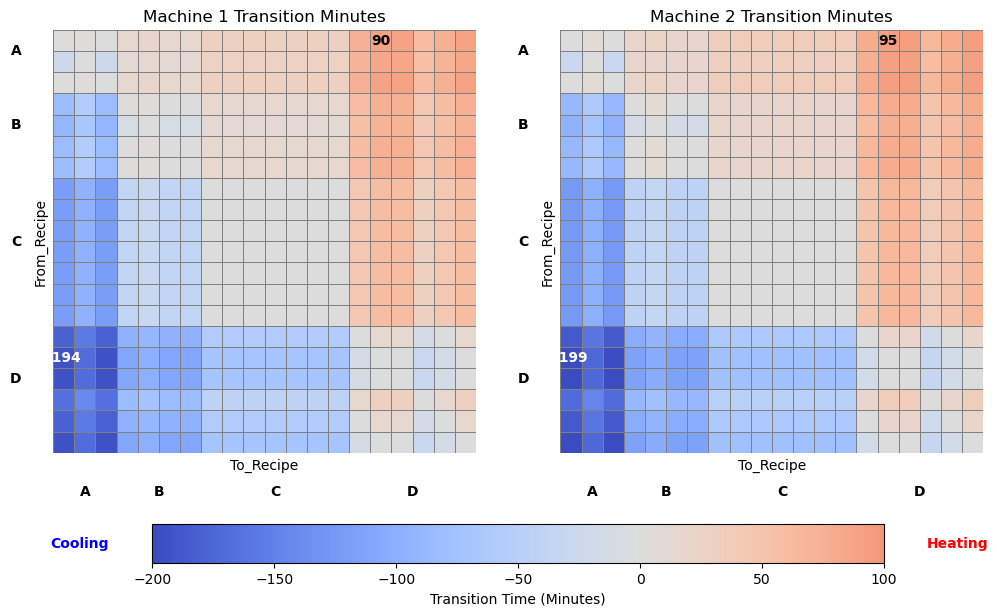

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess data
setup_df = pd.read_pickle("RecipeToRecipe_Setups.pkl")
setup_df['Temp_Diff'] = setup_df['To_Temperature'] - setup_df['From_Temperature']
setup_df['Adjusted_Transition_Time'] = np.where(setup_df['Temp_Diff'] < 0, 
                                                -setup_df['Transition_Time_Minutes'], 
                                                setup_df['Transition_Time_Minutes'])

# Extract cluster information
setup_df['From_Cluster'] = setup_df.index.get_level_values('From_Recipe').str[0]
setup_df['To_Cluster'] = setup_df.index.get_level_values('To_Recipe').str[0]
reset_df = setup_df.reset_index()

# Create pivot tables for both machines
pivot_m1 = reset_df.query("Machine == 1").pivot(index="From_Recipe", columns="To_Recipe", values="Adjusted_Transition_Time")
pivot_m2 = reset_df.query("Machine == 2").pivot(index="From_Recipe", columns="To_Recipe", values="Adjusted_Transition_Time")

# Calculate global min and max for consistent color scaling, rounded to nearest hundred
global_min = round(min(pivot_m1.min().min(), pivot_m2.min().min()), -2)
global_max = round(max(pivot_m1.max().max(), pivot_m2.max().max()), -2)

# Calculate cluster positions
def calculate_cluster_positions(labels, items):
    return {cluster: np.mean([i for i, item in enumerate(items) if item[0] == cluster]) for cluster in labels}

from_cluster_positions = calculate_cluster_positions(sorted(setup_df['From_Cluster'].unique()), pivot_m1.index)
to_cluster_positions = calculate_cluster_positions(sorted(setup_df['To_Cluster'].unique()), pivot_m1.columns)

# Plot heatmaps and add annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

def plot_heatmap(data, ax, title):
    heatmap = sns.heatmap(data, ax=ax, cmap="coolwarm", center=0, square=True, cbar=False, 
                          xticklabels=False, yticklabels=False, linewidths=0.5, linecolor='gray',
                          vmin=global_min, vmax=global_max)  # Set rounded color limits
    ax.set_title(title)
    return heatmap

heatmap1 = plot_heatmap(pivot_m1, axes[0], "Machine 1 Transition Minutes")
heatmap2 = plot_heatmap(pivot_m2, axes[1], "Machine 2 Transition Minutes")

# Annotate min/max values
def annotate_min_max(data, ax, min_color='white', max_color='black'):
    min_val, max_val = data.min().min(), data.max().max()
    min_pos = np.unravel_index(data.values.argmin(), data.shape)
    max_pos = np.unravel_index(data.values.argmax(), data.shape)
    ax.text(min_pos[1] + 0.5, min_pos[0] + 0.5, f'{int(min_val)}', color=min_color, ha='center', va='center', fontweight='bold')
    ax.text(max_pos[1] + 0.5, max_pos[0] + 0.5, f'{int(max_val)}', color=max_color, ha='center', va='center', fontweight='bold')

annotate_min_max(pivot_m1, axes[0])
annotate_min_max(pivot_m2, axes[1])

# Create a single color bar
cbar = fig.colorbar(heatmap1.get_children()[0], ax=axes, orientation='horizontal', fraction=0.05, pad=0.15, aspect=19)
cbar.set_label("Transition Time (Minutes)")

# Annotate "Cooling" and "Heating" on the color bar
cbar.ax.text(-0.1, 0.5, 'Cooling', va='center', ha='center', color='blue', transform=cbar.ax.transAxes, fontweight='bold')
cbar.ax.text(1.1, 0.5, 'Heating', va='center', ha='center', color='red', transform=cbar.ax.transAxes, fontweight='bold')

# Annotate clusters on y-axis and x-axis
def annotate_clusters(ax, positions, y_offset, is_y_axis=True):
    for cluster, position in positions.items():
        if is_y_axis:
            ax.text(-1.5, position + y_offset, cluster, va='center', ha='right', fontweight='bold')
        else:
            ax.text(position + 0.5, y_offset, cluster, va='top', ha='center', fontweight='bold')

for ax in axes:
    annotate_clusters(ax, from_cluster_positions, y_offset=0, is_y_axis=True)
    annotate_clusters(ax, to_cluster_positions, y_offset=pivot_m1.shape[0] + 1.5, is_y_axis=False)

# Adjust layout for color bar
plt.subplots_adjust(bottom=0.22)
plt.savefig('Setup_Transition_Matrix.png')

plt.show()


In [153]:
global_min, global_max

(-200, 100)

In [154]:
setup_df

Transition_Time_Hours  From_Temperature  \
From_Recipe To_Recipe Machine                                            
(A, 6)      (A, 6)    1                       0.0000                50   
                      2                       0.0000                50   
            (A, 13)   1                       0.0500                50   
                      2                       0.0500                50   
            (A, 18)   1                       0.0000                50   
...                                              ...               ...   
(D, 17)     (D, 15)   2                       0.4652               350   
            (D, 16)   1                       0.2112               350   
                      2                       0.2112               350   
            (D, 17)   1                       0.0000               350   
                      2                       0.0000               350   

                               To_Temperature  Transition_Time_Minutes  \
From_Recipe To_Recipe Machine                                            
(A, 6)      (A, 6)    1                    50                        0   
                      2                    50                        0   
            (A, 13)   1                    60                        3   
                      2                    60                        8   
            (A, 18)   1                    50                        0   
...                                       ...                      ...   
(D, 17)     (D, 15)   2                   250                       32   
            (D, 16)   1                   300                       12   
                      2                   300                       17   
            (D, 17)   1                   350                        0   
                      2                   350                        0   

                               Temp_Diff  Adjusted_Transition_Time  \
From_Recipe To_Recipe Machine                                        
(A, 6)      (A, 6)    1                0                         0   
                      2                0                         0   
            (A, 13)   1               10                         3   
                      2               10                         8   
            (A, 18)   1                0                         0   
...                                  ...                       ...   
(D, 17)     (D, 15)   2             -100                       -32   
            (D, 16)   1              -50                       -12   
                      2              -50                       -17   
            (D, 17)   1                0                         0   
                      2                0                         0   

                              From_Cluster To_Cluster  
From_Recipe To_Recipe Machine                          
(A, 6)      (A, 6)    1                  A          A  
                      2                  A          A  
            (A, 13)   1                  A          A  
                      2                  A          A  
            (A, 18)   1                  A          A  
...                                    ...        ...  
(D, 17)     (D, 15)   2                  D          D  
            (D, 16)   1                  D          D  
                      2                  D          D  
            (D, 17)   1                  D          D  
                      2                  D          D  

[800 rows x 8 columns]

#### Visualizing the DES

In [30]:
def create_corrected_flowchart_graphviz():
    # Initialize the directed graph
    dot = Digraph(comment='DES Algorithm Flowchart')

    ### Define nodes
    dot.node('A', 'Start SIMTIME', shape='ellipse')
    dot.node('B', 'Job Arrivals', shape='diamond', width='4', fixedsize='true')
    dot.node('C', 'SIMTIME >= a_true?', shape='triangle', width='4', fixedsize='true')
    dot.node('D', 'Add job to queue', shape='box')
    dot.node('E', 'Delay arrival', shape='box')
    dot.node('F', 'Update job queue', shape='box')
    
    # Sequencing and Filtering
    #dot.node('G', 'Apply sequencing rule?', shape='triangle')
    dot.node('G', 'Apply sequencing rule?', shape='triangle', width='4', fixedsize='true')
    dot.node('H', 'AI: Filter jobs by current or next suggested cluster', shape='box')
    dot.node('I', 'Traditional: Select next job by minimum setup time (nearest neighbor/Greedy)', shape='box')
    dot.node('J', 'Traditional: Tie-break using SPT or LPT', shape='box')
    
    # Resource Request and Processing
    dot.node('K', 'Request machine resource', shape='diamond', width='4', fixedsize='true')
    dot.node('L', 'Machine available?', shape='triangle', width='4', fixedsize='true')
    dot.node('M', 'Process job (Total Time ~ Process + Setup)', shape='box')
    dot.node('N', 'Release machine resource', shape='box')
    
    # Job Completion and Loop
    dot.node('O', 'Job complete', shape='ellipse')
    dot.node('P', 'More jobs in horizon?', shape='triangle', width='4', fixedsize='true')
    dot.node('Q', 'End SIMTIME', shape='ellipse')

    ### Define edges
   # use labels for decision points
    dot.edge('A', 'B')
    dot.edge('B', 'C')
    dot.edge('C', 'D', label='Yes')
    dot.edge('C', 'E', label='No')
    dot.edge('D', 'F')
    dot.edge('E', 'C')
    
    # Sequencing and Filtering Path
    dot.edge('F', 'G')
    dot.edge('G', 'H', label='Yes')
    dot.edge('G', 'I', label='No')  # Directly to "Select next job with min setup time" if sequencing rule is skipped
    dot.edge('H', 'I')
    dot.edge('I', 'J')
    dot.edge('J', 'K')
    
    # Resource Request to Processing
    dot.edge('K', 'L')
    dot.edge('L', 'M', label='Yes')  # If machine is available, process job
    dot.edge('L', 'K', label='No')   # Wait and reattempt to claim machine
    dot.edge('M', 'N')               # After processing, release resource
    dot.edge('N', 'O')
    
    # Completion and Queue Loop
    dot.edge('O', 'P')
    dot.edge('P', 'K', label='Yes')  # Loop back to assign next job
    dot.edge('P', 'Q', label='No')   # End if no more jobs
    
    # Render the corrected flowchart
    return dot

# save the flowchart
corrected_flowchart = create_corrected_flowchart_graphviz()
corrected_flowchart.render(filename='DES_Flowchart', format='png')


'Corrected_DES_Flowchart.png'

#### Optuna Visuals

In [52]:
import optuna
import os
import pickle

## Saving and loading Optuna studies so that the work isn't lost

def save_study(study, folder_path="optuna_studies", study_name="default_study"):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the study as a pickle file
    file_path = os.path.join(folder_path, f"{study_name}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(study, f)
    print(f"Study saved to {file_path}")


def load_study(folder_path="optuna_studies", study_name="default_study"):
    # Load the study from a pickle file
    file_path = os.path.join(folder_path, f"{study_name}.pkl")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No study found at {file_path}")
    
    with open(file_path, "rb") as f:
        study = pickle.load(f)
    print(f"Study loaded from {file_path}")

    # Determine the number of completed trials
    completed_trials = len(study.get_trials(deepcopy=False, 
                                            states=[optuna.trial.TrialState.COMPLETE]))
    print(f"[INFO] Starting from Trial {completed_trials}")
    
    return study


Study loaded from optuna_studies_stochastic/Queue25_Study.pkl
Study loaded from optuna_studies_stochastic/Queue75_Study.pkl


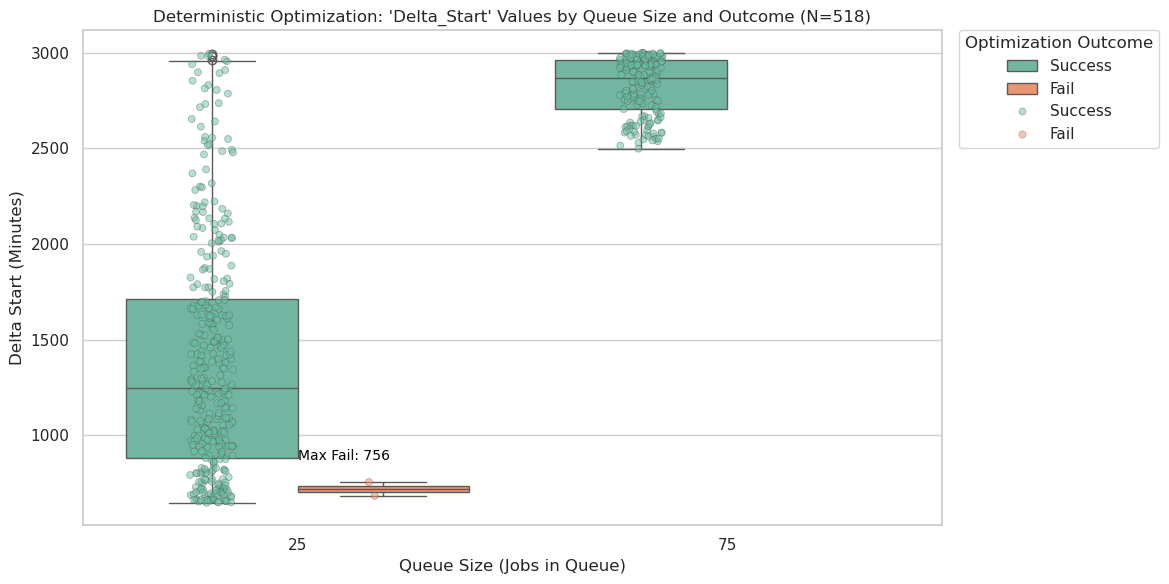

In [85]:
df


,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,204,"{'symmetry_breaking': False, 'mip_focus': 1, '...",16.158771
1,25,204,"{'symmetry_breaking': False, 'mip_focus': 2, '...",15.595391
2,25,204,"{'symmetry_breaking': True, 'mip_focus': 2, 'c...",16.184379
3,25,267,"{'symmetry_breaking': False, 'mip_focus': 1, '...",36.325720
4,25,267,"{'symmetry_breaking': False, 'mip_focus': 2, '...",36.444886
5,25,267,"{'symmetry_breaking': True, 'mip_focus': 2, 'c...",36.325720
6,25,153,"{'symmetry_breaking': False, 'mip_focus': 1, '...",17.933666
7,25,153,"{'symmetry_breaking': False, 'mip_focus': 2, '...",17.963017
8,25,153,"{'symmetry_breaking': True, 'mip_focus': 2, 'c...",18.080423
9,25,10,"{'symmetry_breaking': False, 'mip_focus': 1, '...",28.393715


In [216]:
from statsmodels.formula.api import mixedlm
import pandas as pd

# Load data
df = pd.read_pickle("validation_run_plan_deterministic.pkl")

# Ensure ObjectiveValue is numeric and drop invalid rows
df["ObjectiveValue"] = pd.to_numeric(df["ObjectiveValue"], errors="coerce")
df = df.dropna(subset=["ObjectiveValue"]).copy()

# Add a categorical identifier for hyperparameters (fixed effects for models)
df["Model"] = df["Hyperparameters"].astype(str)

for queue_size in df["QueueSize"].unique():
    print(f"Analyzing QueueSize: {queue_size}")
    df_subset = df[df["QueueSize"] == queue_size]

    # Fit the mixed-effects model
    model = mixedlm(
        formula="ObjectiveValue ~ Model - 1",  # Remove the intercept
        data=df_subset,
        groups=df_subset["ProblemNumber"],
    )
    result = model.fit()

    # Print summary
    display(result.summary())


Analyzing QueueSize: 25


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                     Mixed Linear Model Regression Results
================================================================================================================================================================================
Model:                                                    MixedLM                                       Dependent Variable:                                       ObjectiveValue
No. Observations:                                         30                                            Method:                                                   REML          
No. Groups:                                               10                                            Scale:                                                    0.1316        
Min. group size:                                          3                                             Log-Likelihood:                                           -45.7167      
Max. group size:                                          3                                             Converged:                                                Yes           
Mean group size:                                          3.0                                                                                                                   
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model[{'symmetry_breaking': False, 'mip_focus': 1, 'cuts': 3, 'heuristics': 0.8706962488000624, 'presolve': 0, 'delta_start': 1291}]  23.551    2.154 10.935 0.000 19.330 27.772
Model[{'symmetry_breaking': False, 'mip_focus': 2, 'cuts': 2, 'heuristics': 0.38255324651081446, 'presolve': 2, 'delta_start': 1291}] 23.421    2.154 10.874 0.000 19.199 27.642
Model[{'symmetry_breaking': True, 'mip_focus': 2, 'cuts': 3, 'heuristics': 0.804079855237477, 'presolve': 0, 'delta_start': 1291}]    23.531    2.154 10.925 0.000 19.309 27.752
Group Var                                                                                                                             46.256   73.681                           
================================================================================================================================================================================

"""

Analyzing QueueSize: 75


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Mixed Linear Model Regression Results
==============================================================================================================================================================================
Model:                                                  MixedLM                                       Dependent Variable:                                       ObjectiveValue
No. Observations:                                       30                                            Method:                                                   REML          
No. Groups:                                             10                                            Scale:                                                    0.4429        
Min. group size:                                        3                                             Log-Likelihood:                                           -52.8797      
Max. group size:                                        3                                             Converged:                                                Yes           
Mean group size:                                        3.0                                                                                                                   
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                     Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model[{'symmetry_breaking': False, 'mip_focus': 1, 'cuts': 0, 'heuristics': 0.9544772714508394, 'presolve': 1, 'delta_start': 2509}] 10.719    1.428 7.508 0.000  7.921 13.518
Model[{'symmetry_breaking': False, 'mip_focus': 1, 'cuts': 2, 'heuristics': 0.7991870295315516, 'presolve': 1, 'delta_start': 2509}] 11.281    1.428 7.902 0.000  8.483 14.079
Model[{'symmetry_breaking': True, 'mip_focus': 0, 'cuts': 1, 'heuristics': 0.6720072296006921, 'presolve': 2, 'delta_start': 2509}]  10.612    1.428 7.433 0.000  7.814 13.410
Group Var                                                                                                                            19.941   17.427                          
==============================================================================================================================================================================

"""

In [197]:
np.max(pd.read_pickle("holdout_test_plan_deterministic.pkl")['ObjectiveValue'])

67.74443869632695

In [238]:
sum(pd.read_pickle("holdout_test_plan_deterministic.pkl")['ObjectiveValue'].notna())/400 * 100

81.5

[DEBUG] Plot saved to objective_density_plot_deterministic.png


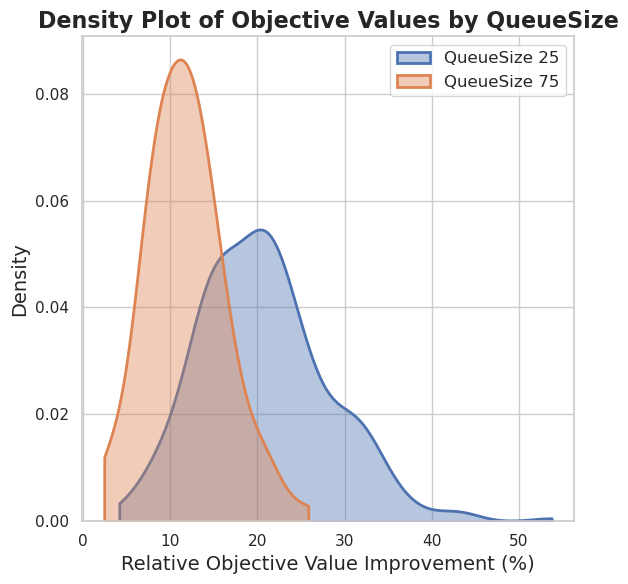

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

def plot_objective_density(filepath, output_file=None):
    """
    Generate and optionally save a density plot for ObjectiveValue by QueueSize.

    Parameters:
    - filepath (str): Path to the input pickle file.
    - output_file (str): Path to save the plot image (optional).
    """
    # Load the data
    df = pd.read_pickle(filepath)

    # Check for infeasible solutions (-100)
    infeasible_count = (df["ObjectiveValue"] == -100).sum()
    if infeasible_count > 0:
        warnings.warn(f"{infeasible_count} infeasible solutions found and removed.")

    # Drop infeasible solutions for this plot only
    df = df[df["ObjectiveValue"] != -100]
        
    # Settings
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    # Density plots by QueueSize
    for queue_size in df["QueueSize"].unique():
        subset = df[df["QueueSize"] == queue_size]
        sns.kdeplot(
            subset["ObjectiveValue"].dropna(),
            fill=True,
            label=f"QueueSize {queue_size}",
            alpha=0.4,
            linewidth=2,
            clip=(subset["ObjectiveValue"].min(), subset["ObjectiveValue"].max())
        )

    # Add labels, title, and legend
    plt.title("Density Plot of Objective Values by QueueSize", fontsize=16, fontweight="bold")
    plt.xlabel("Relative Objective Value Improvement (%)", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    #plt.xlim(0, 5 + df["ObjectiveValue"].max())
    plt.legend(fontsize=12)
    plt.tight_layout()

    
    if output_file:# Save plot
        plt.savefig(output_file, dpi=300)
        print(f"[DEBUG] Plot saved to {output_file}")

    plt.show()

plot_objective_density(
    filepath="holdout_test_plan_deterministic.pkl",
    output_file="objective_density_plot_deterministic.png"
)


In [214]:
df

,QueueSize,ProblemNumber,Hyperparameters,Results,Objective,ObjectiveValue
0,25,1,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,30.047569
1,25,2,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.241935
2,25,3,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,22.756953
3,25,4,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,35.458022
4,25,5,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.656977
...,...,...,...,...,...,...
395,75,96,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,None
396,75,97,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,None
397,75,98,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,None
398,75,99,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,None


In [114]:
7*3.3

23.099999999999998

#### Deterministic Optimization

In [239]:
# import os
# import pickle
# import matplotlib.pyplot as plt
# from optuna.visualization import plot_param_importances, plot_optimization_history
# from PIL import Image
# import io


# def load_study(folder_path="optuna_studies", study_name="default_study"):
#     file_path = os.path.join(folder_path, f"{study_name}.pkl")
#     if not os.path.exists(file_path):
#         raise FileNotFoundError(f"No study found at {file_path}")
#     with open(file_path, "rb") as f:
#         study = pickle.load(f)
#     print(f"Study loaded from {file_path}")
#     return study


# # Load the studies
# study_25 = load_study(folder_path="optuna_studies_deterministic", study_name="Queue25_Study")
# study_75 = load_study(folder_path="optuna_studies_deterministic", study_name="Queue75_Study")

# # Generate parameter importance plots
# param_fig_25 = plot_param_importances(study_25)
# param_fig_75 = plot_param_importances(study_75)

# # Generate optimization history plots
# history_fig_25 = plot_optimization_history(study_25)
# history_fig_75 = plot_optimization_history(study_75)

# # Save each Plotly figure as a separate image
# for plot_type, fig_25, fig_75, name in zip(
#     ["param_importances", "optimization_history"],
#     [param_fig_25, history_fig_25],
#     [param_fig_75, history_fig_75],
#     ["Param Importances", "Optimization History"]
# ):
#     # Save the Queue 25 plot
#     buf_25 = io.BytesIO()
#     fig_25.write_image(buf_25, format="png")
#     buf_25.seek(0)
#     img_25 = Image.open(buf_25)
#     img_25.save(f"{plot_type}_Queue25.png")

#     # Save the Queue 75 plot
#     buf_75 = io.BytesIO()
#     fig_75.write_image(buf_75, format="png")
#     buf_75.seek(0)
#     img_75 = Image.open(buf_75)
#     img_75.save(f"{plot_type}_Queue75.png")


Study loaded from optuna_studies_deterministic/Queue25_Study.pkl
Study loaded from optuna_studies_deterministic/Queue75_Study.pkl


In [237]:
import os
import pickle
import matplotlib.pyplot as plt
from optuna.visualization import plot_param_importances
import io
from PIL import Image

def load_study(folder_path="optuna_studies", study_name="default_study"):
    file_path = os.path.join(folder_path, f"{study_name}.pkl")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No study found at {file_path}")
    with open(file_path, "rb") as f:
        study = pickle.load(f)
    print(f"Study loaded from {file_path}")
    return study

# Load the studies
study_25 = load_study(folder_path="optuna_studies_deterministic", study_name="Queue25_Study")
study_75 = load_study(folder_path="optuna_studies_deterministic", study_name="Queue75_Study")

# Generate and save parameter importance plots for each study
fig_25 = plot_param_importances(study_25)
fig_75 = plot_param_importances(study_75)

# Save each Plotly figure as a separate image
fig_25.write_image("param_importances_Queue25.png", format="png")
fig_75.write_image("param_importances_Queue75.png", format="png")

Study loaded from optuna_studies_deterministic/Queue25_Study.pkl
Study loaded from optuna_studies_deterministic/Queue75_Study.pkl


#### Stochastic Optimization

Study loaded from optuna_studies_stochastic/Queue25_Study.pkl
Study loaded from optuna_studies_stochastic/Queue75_Study.pkl


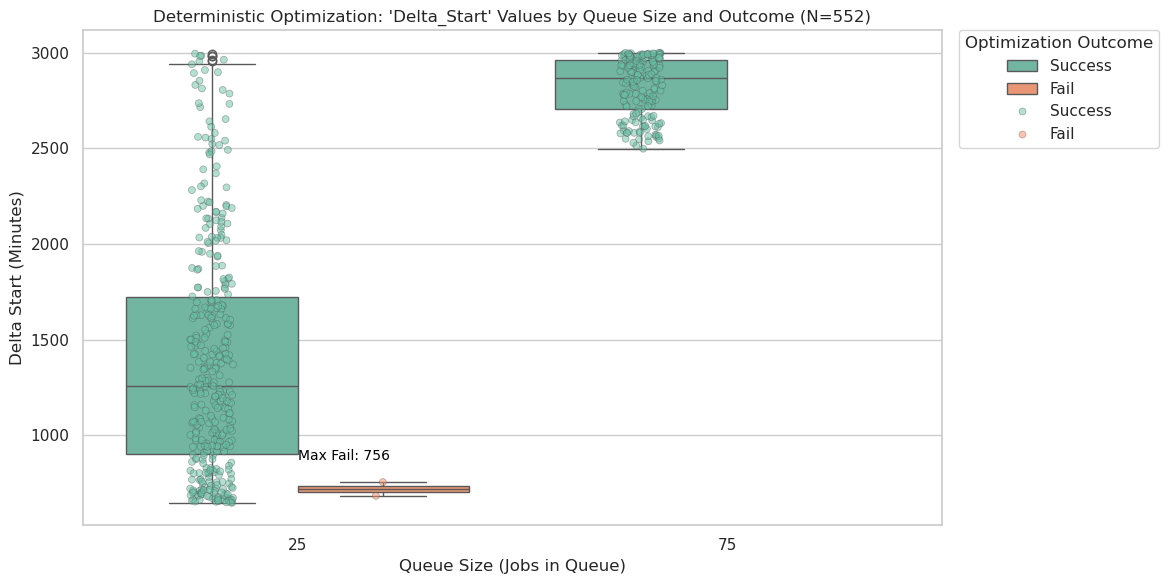

In [274]:
import os
import pickle
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the studies
#folder_path = "optuna_studies_deterministic"
folder_path = "optuna_studies_stochastic"
study_names = ["Queue25_Study", "Queue75_Study"]

studies = {name: load_study(folder_path=folder_path, study_name=name) for name in study_names}

# Extract trial data for visualization
data = []
for study_name, study in studies.items():
    queue_size = int(study_name.split("Queue")[1].split("_")[0])  # Extract queue size from the name
    for trial in study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE]):
        delta_start = trial.params.get("delta_start", None)
        objective_value = trial.values[0] if trial.values else None
        result = "Fail" if objective_value == -100 else "Success"
        data.append({"Queue Size": queue_size, "Delta Start": delta_start, "Result": result})

# Convert to DataFrame
data_df = pd.DataFrame(data)

# Visualization
colorblind_palette = {
    "Success": "#66c2a5",  # Green (colorblind-friendly)
    "Fail": "#fc8d62"      # Red (colorblind-friendly)
}

# Visualization
# Calculate the maximum Delta Start for each Queue Size, focusing only on "Fail" results
fail_max_values = data_df[data_df["Result"] == "Fail"].groupby("Queue Size")["Delta Start"].max().reset_index()

# Plot the boxplot and scatterplot
plt.figure(figsize=(14, 6))  # Slightly larger figure size
sns.boxplot(
    data=data_df, 
    x="Queue Size", 
    y="Delta Start", 
    hue="Result", 
    dodge=True, 
    palette=colorblind_palette
)
sns.stripplot(
    data=data_df, 
    x="Queue Size", 
    y="Delta Start", 
    hue="Result", 
    dodge=True, 
    jitter=True, 
    alpha=0.5, 
    linewidth=0.5, 
    palette=colorblind_palette
)

# Add annotations for the "Fail" maximum values
for _, row in fail_max_values.iterrows():
    x = [25, 75].index(row["Queue Size"])  # Map Queue Size to x-axis position (25 -> 0, 75 -> 1)
    y = row["Delta Start"]
    plt.text(
        x, y + 100,  # Position slightly above the maximum
        f"Max Fail: {int(y)}", 
        ha="left", va="bottom", fontsize=10, color="black"
    )

# Update plot labels and layout
plt.title(f"Deterministic Optimization: 'Delta_Start' Values by Queue Size and Outcome (N={len(data_df)})")
plt.xlabel("Queue Size (Jobs in Queue)")
plt.ylabel("Delta Start (Minutes)")
plt.legend(title="Optimization Outcome", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Add padding to fit everything cleanly

plt.savefig('StochasticOptimizationOptuna.png')
plt.show()



In [276]:
import os
import pickle
import matplotlib.pyplot as plt
from optuna.visualization import plot_param_importances, plot_optimization_history
from PIL import Image
import io


def load_study(folder_path="optuna_studies", study_name="default_study"):
    file_path = os.path.join(folder_path, f"{study_name}.pkl")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No study found at {file_path}")
    with open(file_path, "rb") as f:
        study = pickle.load(f)
    print(f"Study loaded from {file_path}")
    return study


# Load the studies
study_25 = load_study(folder_path="optuna_studies_stochastic", study_name="Queue25_Study")
study_75 = load_study(folder_path="optuna_studies_stochastic", study_name="Queue75_Study")

# Generate parameter importance plots
param_fig_25 = plot_param_importances(study_25)
param_fig_75 = plot_param_importances(study_75)

# Generate optimization history plots
history_fig_25 = plot_optimization_history(study_25)
history_fig_75 = plot_optimization_history(study_75)

# Save each Plotly figure as a separate image
for plot_type, fig_25, fig_75, name in zip(
    ["param_importances", "optimization_history"],
    [param_fig_25, history_fig_25],
    [param_fig_75, history_fig_75],
    ["Param Importances", "Optimization History"]
):
    # Save the Queue 25 plot
    buf_25 = io.BytesIO()
    fig_25.write_image(buf_25, format="png")
    buf_25.seek(0)
    img_25 = Image.open(buf_25)
    img_25.save(f"{plot_type}_Queue25.png")

    # Save the Queue 75 plot
    buf_75 = io.BytesIO()
    fig_75.write_image(buf_75, format="png")
    buf_75.seek(0)
    img_75 = Image.open(buf_75)
    img_75.save(f"{plot_type}_Queue75.png")


Study loaded from optuna_studies_stochastic/Queue25_Study.pkl
Study loaded from optuna_studies_stochastic/Queue75_Study.pkl


In [285]:
display(pd.read_pickle("validation_run_plan_deterministic.pkl").head(6))

,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,204,"{'symmetry_breaking': False, 'mip_focus': 1, '...",16.158771
1,25,204,"{'symmetry_breaking': False, 'mip_focus': 2, '...",15.595391
2,25,204,"{'symmetry_breaking': True, 'mip_focus': 2, 'c...",16.184379
3,25,267,"{'symmetry_breaking': False, 'mip_focus': 1, '...",36.32572
4,25,267,"{'symmetry_breaking': False, 'mip_focus': 2, '...",36.444886
5,25,267,"{'symmetry_breaking': True, 'mip_focus': 2, 'c...",36.32572


In [287]:
display(pd.read_pickle("validation_run_plan_stochastic.pkl").head(6))

,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,204,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",12.932138
1,25,204,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",16.261204
2,25,204,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.75...",15.03201
3,25,267,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",25.403887
4,25,267,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",24.373683
5,25,267,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.75...",25.403887


In [296]:
pd.read_pickle("validation_run_plan_stochastic.pkl")

,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,204,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",12.932138
1,25,204,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",16.261204
2,25,204,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.75...",15.03201
3,25,267,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",25.403887
4,25,267,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",24.373683
5,25,267,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.75...",25.403887
6,25,153,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",23.163539
7,25,153,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",24.101877
8,25,153,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.75...",24.932976
9,25,10,"{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.86...",27.426068


In [298]:
## ensure the df is fully filled out before loading and using the linear mixed effects model

from statsmodels.formula.api import mixedlm
import pandas as pd

# Load data
df = pd.read_pickle("validation_run_plan_stochastic.pkl")

# Ensure ObjectiveValue is numeric and drop invalid rows
df["ObjectiveValue"] = pd.to_numeric(df["ObjectiveValue"], errors="coerce")
df = df.dropna(subset=["ObjectiveValue"]).copy()

# Add a categorical identifier for hyperparameters (fixed effects for models)
df["Model"] = df["Hyperparameters"].astype(str)

for queue_size in df["QueueSize"].unique():
    print(f"Analyzing QueueSize: {queue_size}")
    df_subset = df[df["QueueSize"] == queue_size]

    # Fit the mixed-effects model
    model = mixedlm(
        formula="ObjectiveValue ~ Model - 1",  # Remove the intercept
        data=df_subset,
        groups=df_subset["ProblemNumber"],
    )
    result = model.fit()

    # Print summary
    display(result.summary())


Analyzing QueueSize: 25


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                               Mixed Linear Model Regression Results
====================================================================================================================================================================
Model:                                                MixedLM                                   Dependent Variable:                                   ObjectiveValue
No. Observations:                                     30                                        Method:                                               REML          
No. Groups:                                           10                                        Scale:                                                0.5121        
Min. group size:                                      3                                         Log-Likelihood:                                       -55.5867      
Max. group size:                                      3                                         Converged:                                            Yes           
Mean group size:                                      3.0                                                                                                           
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model[{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.7563919824960467, 'presolve': 1, 'nanmean': False, 'delta_start': 818}] 23.873    1.666 14.327 0.000 20.607 27.139
Model[{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.7684551530323259, 'presolve': 1, 'nanmean': False, 'delta_start': 818}] 23.900    1.666 14.343 0.000 20.634 27.165
Model[{'mip_focus': 3, 'cuts': 3, 'heuristics': 0.8678944201458589, 'presolve': 1, 'nanmean': False, 'delta_start': 818}] 23.218    1.666 13.934 0.000 19.952 26.484
Group Var                                                                                                                 27.254   22.126                           
====================================================================================================================================================================

"""

Analyzing QueueSize: 75


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                               Mixed Linear Model Regression Results
====================================================================================================================================================================
Model:                                                MixedLM                                   Dependent Variable:                                   ObjectiveValue
No. Observations:                                     30                                        Method:                                               REML          
No. Groups:                                           10                                        Scale:                                                1.2327        
Min. group size:                                      3                                         Log-Likelihood:                                       -64.5565      
Max. group size:                                      3                                         Converged:                                            Yes           
Mean group size:                                      3.0                                                                                                           
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                           Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model[{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.5851062188632922, 'presolve': 1, 'nanmean': False, 'delta_start': 2619}]  9.331    1.886 4.948 0.000  5.635 13.026
Model[{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.7242407324722422, 'presolve': 0, 'nanmean': False, 'delta_start': 2619}]  8.402    1.886 4.456 0.000  4.706 12.097
Model[{'mip_focus': 1, 'cuts': 3, 'heuristics': 0.9677167160301956, 'presolve': 0, 'nanmean': False, 'delta_start': 2619}]  7.490    1.886 3.972 0.000  3.794 11.185
Group Var                                                                                                                  34.322   18.061                          
====================================================================================================================================================================

"""

In [301]:
pd.read_pickle("holdout_test_plan_stochastic.pkl")

,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,1,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",28.59408
1,25,2,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",16.639785
2,25,3,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",10.230467
3,25,4,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",None
4,25,5,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",None
...,...,...,...,...
395,75,96,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",None
396,75,97,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",None
397,75,98,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",None
398,75,99,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",None


In [88]:
import pandas as pd
sum(pd.read_pickle("holdout_test_plan_stochastic.pkl")['ObjectiveValue'].notna())/400 * 100

93.0

In [79]:
pd.read_pickle("holdout_test_plan_stochastic.pkl")['ObjectiveValue']

-100

/tmp/ipykernel_607/2843340914.py:25: UserWarning: 2 infeasible solutions found and removed.
  warnings.warn(f"{infeasible_count} infeasible solutions found and removed.")


[DEBUG] Plot saved to objective_density_plot_stochastic.png


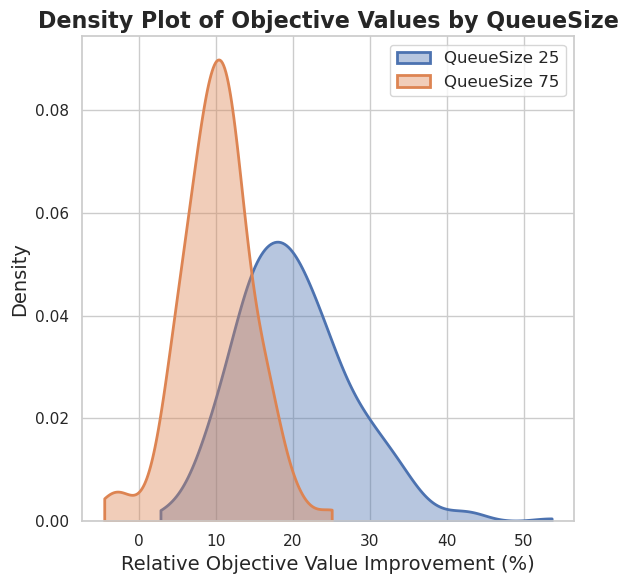

In [118]:
plot_objective_density(
    filepath="holdout_test_plan_stochastic.pkl",
    output_file="objective_density_plot_stochastic.png"
)

### Prepping Holdout Comparisons

#### Fixing bug on deterministic optimization, original used an unfair objective value



In [47]:
holdout_deterministic_df = pd.read_pickle("holdout_test_plan_deterministic.pkl")

##### Need to look at the traditional SPT versus the traditional true SPT

In [12]:
import itertools
import numpy as np
import pandas as pd

def create_solutions_df(
    algorithm,
    problem_sets=[25, 75],
    problems_per_set=[300, 100],
    solutions_per_problem=1,
    columns=['ProblemSet', 'ProblemNumber', 'SolutionNumber', 'Algorithm', 'Sequencing_rule', 'AggregateSolutionData']
):
    # Initialize data list
    data = []

    # Generate combinations of problem sets and problems
    for problem_set, num_problems in zip(problem_sets, problems_per_set):
        problem_numbers = range(1, num_problems + 1)
        solution_numbers = range(1, solutions_per_problem + 1)
        combinations = itertools.product(
            [problem_set], problem_numbers, solution_numbers, [algorithm]
        )
        data.extend(combinations)

    # Convert to array
    data_array = np.array(data)

    # Create placeholders for 'Sequencing_rule' and 'AggregateSolutionData'
    placeholders = np.full((data_array.shape[0], 2), None)
    final_data_array = np.hstack([data_array, placeholders])

    # Create DataFrame
    solutions_df = pd.DataFrame(final_data_array, columns=columns)

    return solutions_df


In [18]:
### Reading the solutions from file directory


# Define algorithms list
algorithms = ['Traditional_SPT', 'Traditional_true_SPT']
exclude_keys = ['job_tracking_df', 'transition_matrix']

for algorithm in algorithms:
    df = create_solutions_df(algorithm)
    file_path_str = f'ProblemSets/Solution_Evaluations_{algorithm}.pkl'
    isTraining = 'Training' in file_path_str

    # Populate DataFrame with data
    solutions_df = populate_aggregate_data(df, algorithm, exclude_keys, isTraining=isTraining)

    # Extract Dict into columns
    sequencing_labels = None ## ASSUMING NO AI algorithms FOR NOW!!!!!!!!!!!!!!! !!!!!!!!!!!!!
    # sequencing_labels = all_sequence_pair_rules['SequencingRuleLabel']
    
    # run function and display without overwriting the original file
    solutions_df = update_training_solutions(file_path_str, sequencing_labels=sequencing_labels)
    
    solutions_df.to_pickle(file_path_str)  # Save DataFrame
    print(f"[DEBUG] Saved DataFrame for {algorithm}.")


Loading Files: 100%|████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 2029.56it/s]


[DEBUG] Saved DataFrame for Traditional_SPT.


Loading Files: 100%|████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1824.67it/s]

[DEBUG] Saved DataFrame for Traditional_true_SPT.


In [21]:
SPT_true_df = pd.read_pickle(f"ProblemSets/Solution_Evaluations_Traditional_true_SPT.pkl")

In [22]:
SPT_expected_df = pd.read_pickle(f"ProblemSets/Solution_Evaluations_Traditional_SPT.pkl")

In [23]:
SPT_expected_df

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,25,1,1,Traditional_SPT,None,"{'max_flow_time': 976, 'avg_makespan': 916.0, ...",976,916.0,946.00,0.09
1,25,2,1,Traditional_SPT,None,"{'max_flow_time': 938, 'avg_makespan': 922.0, ...",938,922.0,930.00,0.24
2,25,3,1,Traditional_SPT,None,"{'max_flow_time': 1067, 'avg_makespan': 1000.5...",1067,1000.5,1033.75,0.21
3,25,4,1,Traditional_SPT,None,"{'max_flow_time': 1560, 'avg_makespan': 1185.5...",1560,1185.5,1372.75,0.17
4,25,5,1,Traditional_SPT,None,"{'max_flow_time': 870, 'avg_makespan': 850.0, ...",870,850.0,860.00,0.23
...,...,...,...,...,...,...,...,...,...,...
395,75,96,1,Traditional_SPT,None,"{'max_flow_time': 3047, 'avg_makespan': 2933.5...",3047,2933.5,2990.25,1.02
396,75,97,1,Traditional_SPT,None,"{'max_flow_time': 2317, 'avg_makespan': 2286.5...",2317,2286.5,2301.75,1.01
397,75,98,1,Traditional_SPT,None,"{'max_flow_time': 2814, 'avg_makespan': 2810.0...",2814,2810.0,2812.00,1.11
398,75,99,1,Traditional_SPT,None,"{'max_flow_time': 2148, 'avg_makespan': 2102.5...",2148,2102.5,2125.25,1.12


In [32]:
working_df = SPT_true_df.merge(SPT_expected_df, 
                               on=['ProblemSet', 'ProblemNumber','SolutionNumber'], 
                               how='left',
                                suffixes=('', '_expected')
                               )[['ProblemSet','ProblemNumber','Algorithm','obj_value','obj_value_expected']]

working_df

,ProblemSet,ProblemNumber,Algorithm,obj_value,obj_value_expected
0,25,1,Traditional_true_SPT,946.00,946.00
1,25,2,Traditional_true_SPT,930.00,930.00
2,25,3,Traditional_true_SPT,889.50,1033.75
3,25,4,Traditional_true_SPT,1203.75,1372.75
4,25,5,Traditional_true_SPT,837.00,860.00
...,...,...,...,...,...
395,75,96,Traditional_true_SPT,2990.25,2990.25
396,75,97,Traditional_true_SPT,2301.75,2301.75
397,75,98,Traditional_true_SPT,2812.00,2812.00
398,75,99,Traditional_true_SPT,2125.25,2125.25


In [34]:
holdout_deterministic_df

,QueueSize,ProblemNumber,Hyperparameters,Results,Objective,ObjectiveValue
0,25,1,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,30.047569
1,25,2,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.241935
2,25,3,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,22.756953
3,25,4,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,35.458022
4,25,5,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.656977
...,...,...,...,...,...,...
395,75,96,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.87986
396,75,97,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,11.447811
397,75,98,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.549431
398,75,99,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,9.151864


In [52]:
# Same typings
working_df['ProblemNumber'] = working_df['ProblemNumber'].astype(str)
holdout_deterministic_df['ProblemNumber'] = holdout_deterministic_df['ProblemNumber'].astype(str)
working_df['ProblemSet'] = working_df['ProblemSet'].astype(str)
holdout_deterministic_df['QueueSize'] = holdout_deterministic_df['QueueSize'].astype(str)

# Left join
fixing_issue_df = working_df.merge(
    holdout_deterministic_df.rename(columns={'ObjectiveValue': 'obj_value', 'QueueSize': 'ProblemSet'})[['ProblemSet','ProblemNumber','obj_value']], # Rename column
    on=['ProblemSet', 'ProblemNumber'],
    how='left',
    suffixes=('', '_DetOptPercent')       # Suffix for duplicate columns
)
fixing_issue_df

,ProblemSet,ProblemNumber,Algorithm,obj_value,obj_value_expected,obj_value_DetOptPercent
0,25,1,Traditional_true_SPT,946.00,946.00,30.047569
1,25,2,Traditional_true_SPT,930.00,930.00,15.241935
2,25,3,Traditional_true_SPT,889.50,1033.75,22.756953
3,25,4,Traditional_true_SPT,1203.75,1372.75,35.458022
4,25,5,Traditional_true_SPT,837.00,860.00,16.656977
...,...,...,...,...,...,...
395,75,96,Traditional_true_SPT,2990.25,2990.25,16.87986
396,75,97,Traditional_true_SPT,2301.75,2301.75,11.447811
397,75,98,Traditional_true_SPT,2812.00,2812.00,15.549431
398,75,99,Traditional_true_SPT,2125.25,2125.25,9.151864


In [60]:
P = fixing_issue_df['obj_value_DetOptPercent'] 
T = fixing_issue_df['obj_value_expected']    

fixing_issue_df['obj_value_DetOpt_Estimated'] = round( T*(1-P/100) , 2)
fixing_issue_df

,ProblemSet,ProblemNumber,Algorithm,obj_value,obj_value_expected,obj_value_DetOptPercent,obj_value_DetOpt_Estimated
0,25,1,Traditional_true_SPT,946.00,946.00,30.047569,661.75
1,25,2,Traditional_true_SPT,930.00,930.00,15.241935,788.25
2,25,3,Traditional_true_SPT,889.50,1033.75,22.756953,798.5
3,25,4,Traditional_true_SPT,1203.75,1372.75,35.458022,886.0
4,25,5,Traditional_true_SPT,837.00,860.00,16.656977,716.75
...,...,...,...,...,...,...,...
395,75,96,Traditional_true_SPT,2990.25,2990.25,16.87986,2485.5
396,75,97,Traditional_true_SPT,2301.75,2301.75,11.447811,2038.25
397,75,98,Traditional_true_SPT,2812.00,2812.00,15.549431,2374.75
398,75,99,Traditional_true_SPT,2125.25,2125.25,9.151864,1930.75


In [62]:
O = fixing_issue_df['obj_value_DetOpt_Estimated'] 
T_new = fixing_issue_df['obj_value']    # the true value to correct it to

fixing_issue_df['obj_value_DetOptPercent_CORRECTED'] = round( (T_new-O)/T_new * 100 , 2)
fixing_issue_df

,ProblemSet,ProblemNumber,Algorithm,obj_value,obj_value_expected,obj_value_DetOptPercent,obj_value_DetOpt_Estimated,obj_value_DetOptPercent_CORRECTED
0,25,1,Traditional_true_SPT,946.00,946.00,30.047569,661.75,30.047569
1,25,2,Traditional_true_SPT,930.00,930.00,15.241935,788.25,15.241935
2,25,3,Traditional_true_SPT,889.50,1033.75,22.756953,798.5,10.230467
3,25,4,Traditional_true_SPT,1203.75,1372.75,35.458022,886.0,26.396677
4,25,5,Traditional_true_SPT,837.00,860.00,16.656977,716.75,14.366786
...,...,...,...,...,...,...,...,...
395,75,96,Traditional_true_SPT,2990.25,2990.25,16.87986,2485.5,16.87986
396,75,97,Traditional_true_SPT,2301.75,2301.75,11.447811,2038.25,11.447811
397,75,98,Traditional_true_SPT,2812.00,2812.00,15.549431,2374.75,15.549431
398,75,99,Traditional_true_SPT,2125.25,2125.25,9.151864,1930.75,9.151864


In [63]:
pd.read_pickle("holdout_test_plan_deterministic.pkl")

,QueueSize,ProblemNumber,Hyperparameters,Results,Objective,ObjectiveValue
0,25,1,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,30.047569
1,25,2,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.241935
2,25,3,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,22.756953
3,25,4,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,35.458022
4,25,5,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.656977
...,...,...,...,...,...,...
395,75,96,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.87986
396,75,97,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,11.447811
397,75,98,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.549431
398,75,99,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,9.151864


In [66]:
# Ensure matching types for keys
fixing_issue_df['ProblemSet'] = fixing_issue_df['ProblemSet'].astype(str)
holdout_deterministic_df['QueueSize'] = holdout_deterministic_df['QueueSize'].astype(str)

# Merge DataFrames on keys
merged_df = holdout_deterministic_df.merge(
    fixing_issue_df[['ProblemSet', 'ProblemNumber', 'obj_value_DetOptPercent_CORRECTED']],
    left_on=['QueueSize', 'ProblemNumber'],
    right_on=['ProblemSet', 'ProblemNumber'],
    how='left'
)

merged_df.rename(columns={'ObjectiveValue': 'ObjectiveValue_old'}, inplace=True)

# Ensure ObjectiveValue columns are numeric
merged_df['obj_value_DetOptPercent_CORRECTED'] = pd.to_numeric(merged_df['obj_value_DetOptPercent_CORRECTED'], errors='coerce')
merged_df['ObjectiveValue_old'] = pd.to_numeric(merged_df['ObjectiveValue_old'], errors='coerce')
merged_df['ObjectiveValue'] = merged_df['obj_value_DetOptPercent_CORRECTED'].combine_first(merged_df['ObjectiveValue_old']) # Replace with corrected values safely

merged_df.drop(columns=['ProblemSet', 'obj_value_DetOptPercent_CORRECTED'], inplace=True)

# Display updated DataFrame
display(merged_df)


,QueueSize,ProblemNumber,Hyperparameters,Results,Objective,ObjectiveValue_old,ObjectiveValue
0,25,1,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,30.047569,30.047569
1,25,2,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.241935,15.241935
2,25,3,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,22.756953,10.230467
3,25,4,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,35.458022,26.396677
4,25,5,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.656977,14.366786
...,...,...,...,...,...,...,...
395,75,96,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.879860,16.879860
396,75,97,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,11.447811,11.447811
397,75,98,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.549431,15.549431
398,75,99,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,9.151864,9.151864


In [67]:
merged_df.to_pickle('holdout_test_plan_deterministic.pkl')

#### AI_true_LPT simulating and storing

In [97]:
# Define algorithms list
algorithms = ['AI_true_LPT']
exclude_keys = ['job_tracking_df', 'transition_matrix']

for algorithm in algorithms:
    df = create_solutions_df(algorithm, solutions_per_problem=36)
    file_path_str = f'ProblemSets/Solution_Evaluations_{algorithm}.pkl'
    isTraining = 'Training' in file_path_str

    #sequencing_labels = None ## ASSUMING NO AI algorithms FOR NOW!!!!!!!!!!!!!!! !!!!!!!!!!!!!
    sequencing_labels = all_sequence_pair_rules['SequencingRuleLabel']

    # Populate DataFrame with data
    #solutions_df = #populate_aggregate_data(df, algorithm, exclude_keys, isTraining=isTraining)

    # Extract Dict into columns


In [101]:
df

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,25,1,1,AI_true_LPT,None,None
1,25,1,2,AI_true_LPT,None,None
2,25,1,3,AI_true_LPT,None,None
3,25,1,4,AI_true_LPT,None,None
4,25,1,5,AI_true_LPT,None,None
...,...,...,...,...,...,...
14395,75,100,32,AI_true_LPT,None,None
14396,75,100,33,AI_true_LPT,None,None
14397,75,100,34,AI_true_LPT,None,None
14398,75,100,35,AI_true_LPT,None,None


In [100]:
run_all_simulations(df,
                    is_arrival_time_expected = False, # we have all known times now because we are evaluating with a single sequence
                    isTraining = False)

100%|█████████████████████████████████████████████████████████████████████████████| 14400/14400 [14:42<00:00, 16.32it/s]


In [102]:
### reading all the solutions

In [106]:
df

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData
0,25,1,1,AI_true_LPT,None,"{'max_flow_time': 1096, 'avg_makespan': 1032.5..."
1,25,1,2,AI_true_LPT,None,"{'max_flow_time': 889, 'avg_makespan': 875.5, ..."
2,25,1,3,AI_true_LPT,None,"{'max_flow_time': 895, 'avg_makespan': 883.5, ..."
3,25,1,4,AI_true_LPT,None,"{'max_flow_time': 994, 'avg_makespan': 833.5, ..."
4,25,1,5,AI_true_LPT,None,"{'max_flow_time': 982, 'avg_makespan': 934.0, ..."
...,...,...,...,...,...,...
14395,75,100,32,AI_true_LPT,None,"{'max_flow_time': 2810, 'avg_makespan': 2350.5..."
14396,75,100,33,AI_true_LPT,None,"{'max_flow_time': 2203, 'avg_makespan': 2182.0..."
14397,75,100,34,AI_true_LPT,None,"{'max_flow_time': 2602, 'avg_makespan': 2266.5..."
14398,75,100,35,AI_true_LPT,None,"{'max_flow_time': 2820, 'avg_makespan': 2324.5..."


In [107]:
# Populate DataFrame with data
solutions_df = populate_aggregate_data(df, algorithm, exclude_keys, isTraining=isTraining)

solutions_df.to_pickle(file_path_str)  # Save DataFrame
print(f"[DEBUG] Saved DataFrame for {'AI_true_LPT'}.")

# Extract Dict into columns
sequencing_labels = all_sequence_pair_rules['SequencingRuleLabel']

# run function and display without overwriting the original file
solutions_df = update_training_solutions(file_path_str, sequencing_labels=sequencing_labels)



Loading Files: 0it [00:00, ?it/s]


[DEBUG] Saved DataFrame for AI_true_LPT.


In [108]:
solutions_df

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,25,1,1,AI_true_LPT,"(1, 1)","{'max_flow_time': 1096, 'avg_makespan': 1032.5...",1096,1032.5,1064.25,0.21
1,25,1,2,AI_true_LPT,"(1, 2)","{'max_flow_time': 889, 'avg_makespan': 875.5, ...",889,875.5,882.25,0.25
2,25,1,3,AI_true_LPT,"(1, 3)","{'max_flow_time': 895, 'avg_makespan': 883.5, ...",895,883.5,889.25,0.23
3,25,1,4,AI_true_LPT,"(1, 4)","{'max_flow_time': 994, 'avg_makespan': 833.5, ...",994,833.5,913.75,0.20
4,25,1,5,AI_true_LPT,"(1, 5)","{'max_flow_time': 982, 'avg_makespan': 934.0, ...",982,934.0,958.00,0.26
...,...,...,...,...,...,...,...,...,...,...
14395,75,100,32,AI_true_LPT,"(6, 2)","{'max_flow_time': 2810, 'avg_makespan': 2350.5...",2810,2350.5,2580.25,0.99
14396,75,100,33,AI_true_LPT,"(6, 3)","{'max_flow_time': 2203, 'avg_makespan': 2182.0...",2203,2182.0,2192.50,0.98
14397,75,100,34,AI_true_LPT,"(6, 4)","{'max_flow_time': 2602, 'avg_makespan': 2266.5...",2602,2266.5,2434.25,0.86
14398,75,100,35,AI_true_LPT,"(6, 5)","{'max_flow_time': 2820, 'avg_makespan': 2324.5...",2820,2324.5,2572.25,0.86


In [111]:
# getting max per problem set and number
max_obj_value_df = (
    solutions_df.groupby(['ProblemSet', 'ProblemNumber'], as_index=False)
    .apply(lambda group: group.loc[group['obj_value'].idxmin()], include_groups=False)
    .reset_index(drop=True)
)

display(max_obj_value_df)

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,25,1,10,AI_true_LPT,"(2, 4)","{'max_flow_time': 847, 'avg_makespan': 835.0, ...",847,835.0,841.00,0.23
1,25,10,3,AI_true_LPT,"(1, 3)","{'max_flow_time': 1220, 'avg_makespan': 1028.5...",1220,1028.5,1124.25,0.21
2,25,100,4,AI_true_LPT,"(1, 4)","{'max_flow_time': 1182, 'avg_makespan': 902.5,...",1182,902.5,1042.25,0.23
3,25,101,2,AI_true_LPT,"(1, 2)","{'max_flow_time': 861, 'avg_makespan': 852.5, ...",861,852.5,856.75,0.22
4,25,102,13,AI_true_LPT,"(3, 1)","{'max_flow_time': 858, 'avg_makespan': 810.5, ...",858,810.5,834.25,0.19
...,...,...,...,...,...,...,...,...,...,...
395,75,95,8,AI_true_LPT,"(2, 2)","{'max_flow_time': 2527, 'avg_makespan': 2505.0...",2527,2505.0,2516.00,1.59
396,75,96,3,AI_true_LPT,"(1, 3)","{'max_flow_time': 3047, 'avg_makespan': 2853.0...",3047,2853.0,2950.00,1.79
397,75,97,3,AI_true_LPT,"(1, 3)","{'max_flow_time': 2187, 'avg_makespan': 2158.5...",2187,2158.5,2172.75,1.48
398,75,98,21,AI_true_LPT,"(4, 3)","{'max_flow_time': 2683, 'avg_makespan': 2659.0...",2683,2659.0,2671.00,1.74


In [124]:
max_obj_value_df.rename(columns={'obj_value': 'ObjectiveValue'}, inplace=True) 

max_obj_value_df[['ProblemSet', 'ProblemNumber', 'ObjectiveValue', 'Sequencing_rule', 'SolutionNumber', 'runtime_seconds']]

,ProblemSet,ProblemNumber,ObjectiveValue,Sequencing_rule,SolutionNumber,runtime_seconds
0,25,1,841.00,"(2, 4)",10,0.23
1,25,10,1124.25,"(1, 3)",3,0.21
2,25,100,1042.25,"(1, 4)",4,0.23
3,25,101,856.75,"(1, 2)",2,0.22
4,25,102,834.25,"(3, 1)",13,0.19
...,...,...,...,...,...,...
395,75,95,2516.00,"(2, 2)",8,1.59
396,75,96,2950.00,"(1, 3)",3,1.79
397,75,97,2172.75,"(1, 3)",3,1.48
398,75,98,2671.00,"(4, 3)",21,1.74


In [125]:
SPT_true_df

,ProblemSet,ProblemNumber,SolutionNumber,Algorithm,Sequencing_rule,AggregateSolutionData,max_flow_time,avg_makespan,obj_value,runtime_seconds
0,25,1,1,Traditional_true_SPT,None,"{'max_flow_time': 976, 'avg_makespan': 916.0, ...",976,916.0,946.00,0.19
1,25,2,1,Traditional_true_SPT,None,"{'max_flow_time': 938, 'avg_makespan': 922.0, ...",938,922.0,930.00,0.22
2,25,3,1,Traditional_true_SPT,None,"{'max_flow_time': 852, 'avg_makespan': 927.0, ...",852,927.0,889.50,0.19
3,25,4,1,Traditional_true_SPT,None,"{'max_flow_time': 1354, 'avg_makespan': 1053.5...",1354,1053.5,1203.75,0.20
4,25,5,1,Traditional_true_SPT,None,"{'max_flow_time': 848, 'avg_makespan': 826.0, ...",848,826.0,837.00,0.21
...,...,...,...,...,...,...,...,...,...,...
395,75,96,1,Traditional_true_SPT,None,"{'max_flow_time': 3047, 'avg_makespan': 2933.5...",3047,2933.5,2990.25,0.99
396,75,97,1,Traditional_true_SPT,None,"{'max_flow_time': 2317, 'avg_makespan': 2286.5...",2317,2286.5,2301.75,0.85
397,75,98,1,Traditional_true_SPT,None,"{'max_flow_time': 2814, 'avg_makespan': 2810.0...",2814,2810.0,2812.00,1.01
398,75,99,1,Traditional_true_SPT,None,"{'max_flow_time': 2148, 'avg_makespan': 2102.5...",2148,2102.5,2125.25,0.97


In [128]:
# tidying
max_obj_value_df['ProblemSet'] = max_obj_value_df['ProblemSet'].astype(str)
SPT_true_df['ProblemSet'] = SPT_true_df['ProblemSet'].astype(str)
SPT_true_df.rename(columns={'obj_value': 'ObjectiveValue'}, inplace=True)

merged_df = max_obj_value_df[['ProblemSet', 'ProblemNumber', 'ObjectiveValue', 'Sequencing_rule', 'SolutionNumber', 'runtime_seconds']].merge(
    SPT_true_df[['ProblemSet', 'ProblemNumber','ObjectiveValue']],
    left_on=['ProblemSet', 'ProblemNumber'], 
    right_on=['ProblemSet', 'ProblemNumber'],
    how='inner',
    suffixes=('', '_traditional')  # Distinguish columns
)

# Show merged DataFrame
display(merged_df)


,ProblemSet,ProblemNumber,ObjectiveValue,Sequencing_rule,SolutionNumber,runtime_seconds,ObjectiveValue_traditional
0,25,1,841.00,"(2, 4)",10,0.23,946.00
1,25,10,1124.25,"(1, 3)",3,0.21,1285.50
2,25,100,1042.25,"(1, 4)",4,0.23,1131.50
3,25,101,856.75,"(1, 2)",2,0.22,866.00
4,25,102,834.25,"(3, 1)",13,0.19,890.00
...,...,...,...,...,...,...,...
395,75,95,2516.00,"(2, 2)",8,1.59,2400.75
396,75,96,2950.00,"(1, 3)",3,1.79,2990.25
397,75,97,2172.75,"(1, 3)",3,1.48,2301.75
398,75,98,2671.00,"(4, 3)",21,1.74,2812.00


In [130]:
O = merged_df['ObjectiveValue'] 
T = merged_df['ObjectiveValue_traditional']    # the true value to correct it to

merged_df['ObjectiveValue_Percent'] = round( (T-O)/T * 100 , 2)
merged_df.rename(columns={'ObjectiveValue': 'ObjectiveValue_old', 'ObjectiveValue_traditional': 'ObjectiveValue_traditional_old', 'ObjectiveValue_Percent':'ObjectiveValue'}, inplace=True)

In [149]:
merged_df

,ProblemSet,ProblemNumber,ObjectiveValue_old,Sequencing_rule,SolutionNumber,runtime_seconds,ObjectiveValue_traditional_old,ObjectiveValue
0,25,1,841.00,"(2, 4)",10,0.23,946.00,11.10
1,25,10,1124.25,"(1, 3)",3,0.21,1285.50,12.54
2,25,100,1042.25,"(1, 4)",4,0.23,1131.50,7.89
3,25,101,856.75,"(1, 2)",2,0.22,866.00,1.07
4,25,102,834.25,"(3, 1)",13,0.19,890.00,6.26
...,...,...,...,...,...,...,...,...
395,75,95,2516.00,"(2, 2)",8,1.59,2400.75,-4.80
396,75,96,2950.00,"(1, 3)",3,1.79,2990.25,1.35
397,75,97,2172.75,"(1, 3)",3,1.48,2301.75,5.60
398,75,98,2671.00,"(4, 3)",21,1.74,2812.00,5.01


In [152]:
merged_df.rename(columns={'ProblemSet': 'QueueSize'}, inplace=True)
merged_df

,QueueSize,ProblemNumber,ObjectiveValue_old,Sequencing_rule,SolutionNumber,runtime_seconds,ObjectiveValue_traditional_old,ObjectiveValue
0,25,1,841.00,"(2, 4)",10,0.23,946.00,11.10
1,25,10,1124.25,"(1, 3)",3,0.21,1285.50,12.54
2,25,100,1042.25,"(1, 4)",4,0.23,1131.50,7.89
3,25,101,856.75,"(1, 2)",2,0.22,866.00,1.07
4,25,102,834.25,"(3, 1)",13,0.19,890.00,6.26
...,...,...,...,...,...,...,...,...
395,75,95,2516.00,"(2, 2)",8,1.59,2400.75,-4.80
396,75,96,2950.00,"(1, 3)",3,1.79,2990.25,1.35
397,75,97,2172.75,"(1, 3)",3,1.48,2301.75,5.60
398,75,98,2671.00,"(4, 3)",21,1.74,2812.00,5.01


In [153]:
merged_df.to_pickle('holdout_test_plan_AI_true_LPT.pkl')

### AI and Total Holdout Evaluation Comparisons

- I also tried out Joyplot but did not go in that direction.

In [119]:
pd.read_pickle(f"holdout_test_plan_AI_true_LPT.pkl")

,ProblemSet,ProblemNumber,ObjectiveValue,Sequencing_rule,SolutionNumber,runtime_seconds
0,25,1,841.00,"(2, 4)",10,0.23
1,25,10,1124.25,"(1, 3)",3,0.21
2,25,100,1042.25,"(1, 4)",4,0.23
3,25,101,856.75,"(1, 2)",2,0.22
4,25,102,834.25,"(3, 1)",13,0.19
...,...,...,...,...,...,...
395,75,95,2516.00,"(2, 2)",8,1.59
396,75,96,2950.00,"(1, 3)",3,1.79
397,75,97,2172.75,"(1, 3)",3,1.48
398,75,98,2671.00,"(4, 3)",21,1.74


In [120]:
pd.read_pickle(f"holdout_test_plan_deterministic.pkl")

,QueueSize,ProblemNumber,Hyperparameters,Results,Objective,ObjectiveValue_old,ObjectiveValue
0,25,1,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,30.047569,30.047569
1,25,2,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.241935,15.241935
2,25,3,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,22.756953,10.230467
3,25,4,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,35.458022,26.396677
4,25,5,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.656977,14.366786
...,...,...,...,...,...,...,...
395,75,96,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,16.879860,16.879860
396,75,97,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,11.447811,11.447811
397,75,98,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,15.549431,15.549431
398,75,99,"{'symmetry_breaking': False, 'mip_focus': 1, '...",{},None,9.151864,9.151864


In [122]:
pd.read_pickle(f"holdout_test_plan_stochastic.pkl")

,QueueSize,ProblemNumber,Hyperparameters,ObjectiveValue
0,25,1,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",28.59408
1,25,2,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",16.639785
2,25,3,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",10.230467
3,25,4,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",24.402908
4,25,5,"{'mip_focus': 0, 'cuts': 3, 'heuristics': 0.76...",14.366786
...,...,...,...,...
395,75,96,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",15.767912
396,75,97,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",11.013359
397,75,98,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",13.522404
398,75,99,"{'mip_focus': 1, 'cuts': 2, 'heuristics': 0.58...",8.375485


In [157]:
import pandas as pd

# Load DataFrames
ai_true_lpt_df = pd.read_pickle("holdout_test_plan_AI_true_LPT.pkl")
deterministic_df = pd.read_pickle("holdout_test_plan_deterministic.pkl")
stochastic_df = pd.read_pickle("holdout_test_plan_stochastic.pkl")

# Add 'Algorithm' column and standardize columns
ai_true_lpt_df["Algorithm"] = "AI_true_LPT"
deterministic_df["Algorithm"] = "DeterministicOpt"
stochastic_df["Algorithm"] = "StochasticOpt"


In [158]:
# ## JOY PLOT! Plus merge

# Keep only necessary columns and combine DataFrames
combined_df = pd.concat(
    [
        ai_true_lpt_df[["QueueSize", "ProblemNumber", "ObjectiveValue", "Algorithm"]],
        deterministic_df[["QueueSize", "ProblemNumber", "ObjectiveValue", "Algorithm"]],
        stochastic_df[["QueueSize", "ProblemNumber", "ObjectiveValue", "Algorithm"]],
    ],
    ignore_index=True
)

# Display the resulting DataFrame
display(combined_df)

# # Check and filter infeasible solutions
# infeasible_count = (combined_df['ObjectiveValue'] == -100).sum()
# if infeasible_count > 0:
#     warnings.warn(f"{infeasible_count} infeasible solutions found and removed.")

# # Filter out infeasible rows
# combined_df = combined_df[combined_df['ObjectiveValue'] != -100]

# # Ensure column types
# combined_df['ObjectiveValue'] = pd.to_numeric(combined_df['ObjectiveValue'], errors='coerce')
# combined_df['QueueSize'] = combined_df['ProblemSet'].astype(str)

# # Create normalized column
# combined_df['RelativeObjectiveImprovement'] = combined_df['ObjectiveValue']

# # Compute min and max bounds
# group_bounds = combined_df.groupby(['Algorithm', 'QueueSize'])['RelativeObjectiveImprovement'].agg(['min', 'max']).reset_index()

# # Merge bounds back into the DataFrame
# combined_df = combined_df.merge(group_bounds, on=['Algorithm', 'QueueSize'], how='left')

# # Create categorical labels
# algorithm_order = ["AI_true_LPT", "DeterministicOpt", "StochasticOpt"]
# combined_df["Algorithm"] = pd.Categorical(combined_df["Algorithm"], categories=algorithm_order, ordered=True)
# combined_df['Y_Label'] = combined_df['Algorithm'].astype(str) + " (QueueSize " + combined_df['QueueSize'] + ")"

# # Generate plot
# plt.figure(figsize=(10, 10))

# # Generate the Joy Plot with clipping
# ax = joyplot(
#     data=combined_df,
#     by="Y_Label",
#     column="RelativeObjectiveImprovement",
#     colormap=plt.cm.viridis,
#     fade=True,
#     overlap=0.2,
#     range_style='own',
#     x_range=(combined_df['min'].min(), combined_df['max'].max())  # Clipping applied globally
# )

# # Add labels and reference lines
# plt.xlabel("Relative Objective Value Improvement (%)", fontsize=10)
# plt.axvline(x=0, color="red", linestyle="--", linewidth=1.2)
# plt.axvline(x=10, color="green", linestyle="--", linewidth=1)
# plt.axvline(x=20, color="green", linestyle="--", linewidth=1)
# plt.axvline(x=30, color="green", linestyle="--", linewidth=1)

# plt.tight_layout()
# plt.show()

,QueueSize,ProblemNumber,ObjectiveValue,Algorithm
0,25,1,11.1,AI_true_LPT
1,25,10,12.54,AI_true_LPT
2,25,100,7.89,AI_true_LPT
3,25,101,1.07,AI_true_LPT
4,25,102,6.26,AI_true_LPT
...,...,...,...,...
1195,75,96,15.767912,StochasticOpt
1196,75,97,11.013359,StochasticOpt
1197,75,98,13.522404,StochasticOpt
1198,75,99,8.375485,StochasticOpt


In [160]:
combined_df

,QueueSize,ProblemNumber,ObjectiveValue,Algorithm
0,25,1,11.1,AI_true_LPT
1,25,10,12.54,AI_true_LPT
2,25,100,7.89,AI_true_LPT
3,25,101,1.07,AI_true_LPT
4,25,102,6.26,AI_true_LPT
...,...,...,...,...
1195,75,96,15.767912,StochasticOpt
1196,75,97,11.013359,StochasticOpt
1197,75,98,13.522404,StochasticOpt
1198,75,99,8.375485,StochasticOpt


[DEBUG] Plot saved to objective_density_plot_AI_true_LPT.png


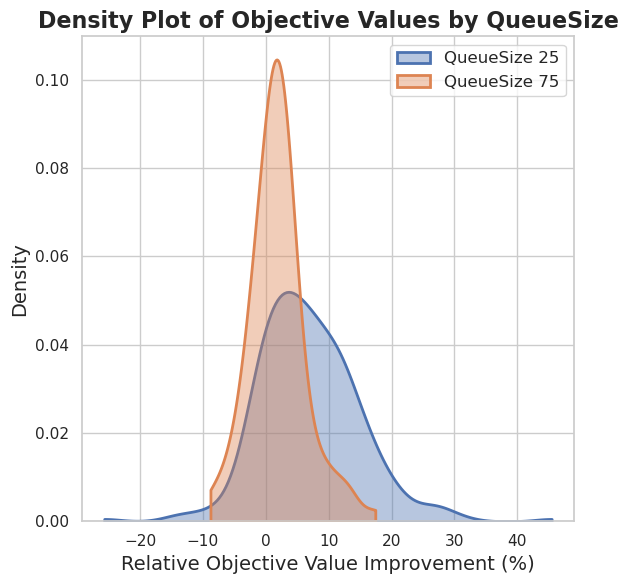

In [156]:
plot_objective_density(
    filepath="holdout_test_plan_AI_true_LPT.pkl",
    output_file="objective_density_plot_AI_true_LPT.png"
)


In [171]:
np.min(df['ObjectiveValue'])

-100.0

In [193]:
combined_df[combined_df['Algorithm']=='StochasticOpt'].sort_values(by='ProblemNumber', ascending=False)

,QueueSize,ProblemNumber,ObjectiveValue,Algorithm,Model
1099,25,300,20.696008,StochasticOpt,StochasticOpt
1098,25,299,17.779473,StochasticOpt,StochasticOpt
1097,25,298,14.456427,StochasticOpt,StochasticOpt
1096,25,297,22.780305,StochasticOpt,StochasticOpt
1095,25,296,17.632979,StochasticOpt,StochasticOpt
...,...,...,...,...,...
1102,75,3,9.390244,StochasticOpt,StochasticOpt
1101,75,2,13.950711,StochasticOpt,StochasticOpt
801,25,2,16.639785,StochasticOpt,StochasticOpt
1100,75,1,9.131380,StochasticOpt,StochasticOpt


In [211]:
from statsmodels.formula.api import mixedlm
import pandas as pd
import numpy as np

# Load data
df = combined_df
df["QueueSize"] = df["QueueSize"].astype(int)
df["ProblemNumber"] = df["ProblemNumber"].astype(int)

# Ensure ObjectiveValue is numeric and drop invalid rows
df["ObjectiveValue"] = pd.to_numeric(df["ObjectiveValue"], errors="coerce")
df["ObjectiveValue"] = df["ObjectiveValue"].replace(np.nan, -100)

# Add a categorical identifier for hyperparameters (fixed effects for models)
df["Model"] = df["Algorithm"].astype(str)

for queue_size in df["QueueSize"].unique():
    print(f"Analyzing QueueSize: {queue_size}")
    
    # Subset the data
    df_subset = df[df["QueueSize"] == queue_size]

    # Fit the mixed-effects model
    try:
        model = mixedlm(
            formula="ObjectiveValue ~ Model - 1",  # Include intercept
            data=df_subset,
            groups=df_subset["ProblemNumber"]
        )
        result = model.fit()

        # Print summary
        display(result.summary())
    except Exception as e:
        print(f"Error analyzing QueueSize {queue_size}: {e}")


Analyzing QueueSize: 25


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   ObjectiveValue
No. Observations:   898       Method:               REML          
No. Groups:         300       Scale:                18.9086       
Min. group size:    2         Log-Likelihood:       -2891.4754    
Max. group size:    3         Converged:            Yes           
Mean group size:    3.0                                           
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Model[AI_true_LPT]       6.838    0.443 15.442 0.000  5.970  7.705
Model[DeterministicOpt] 20.680    0.443 46.705 0.000 19.812 21.548
Model[StochasticOpt]    20.224    0.443 45.607 0.000 19.355 21.094
Group Var               39.907    1.068                           
==================================================================

"""

Analyzing QueueSize: 75


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:              MixedLM   Dependent Variable:   ObjectiveValue
No. Observations:   300       Method:               REML          
No. Groups:         100       Scale:                5.4483        
Min. group size:    3         Log-Likelihood:       -791.2773     
Max. group size:    3         Converged:            Yes           
Mean group size:    3.0                                           
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Model[AI_true_LPT]       1.798    0.456  3.942 0.000  0.904  2.692
Model[DeterministicOpt] 11.708    0.456 25.671 0.000 10.814 12.601
Model[StochasticOpt]    10.088    0.456 22.121 0.000  9.195 10.982
Group Var               15.351    1.280                           
==================================================================

"""

In [209]:
df.sort_values('ObjectiveValue')


,QueueSize,ProblemNumber,ObjectiveValue,Algorithm,Model,Infeasible
276,25,78,-25.710000,AI_true_LPT,AI_true_LPT,False
56,25,15,-14.550000,AI_true_LPT,AI_true_LPT,False
57,25,150,-13.660000,AI_true_LPT,AI_true_LPT,False
26,25,122,-11.480000,AI_true_LPT,AI_true_LPT,False
147,25,231,-9.890000,AI_true_LPT,AI_true_LPT,False
...,...,...,...,...,...,...
908,25,109,43.209361,StochasticOpt,StochasticOpt,False
508,25,109,43.564563,DeterministicOpt,DeterministicOpt,False
141,25,226,45.480000,AI_true_LPT,AI_true_LPT,False
1025,25,226,53.616894,StochasticOpt,StochasticOpt,False
